Calculating global minimum accuracy...
Global minimum f1: 0.0%

Creating combined heatmap for vessel...


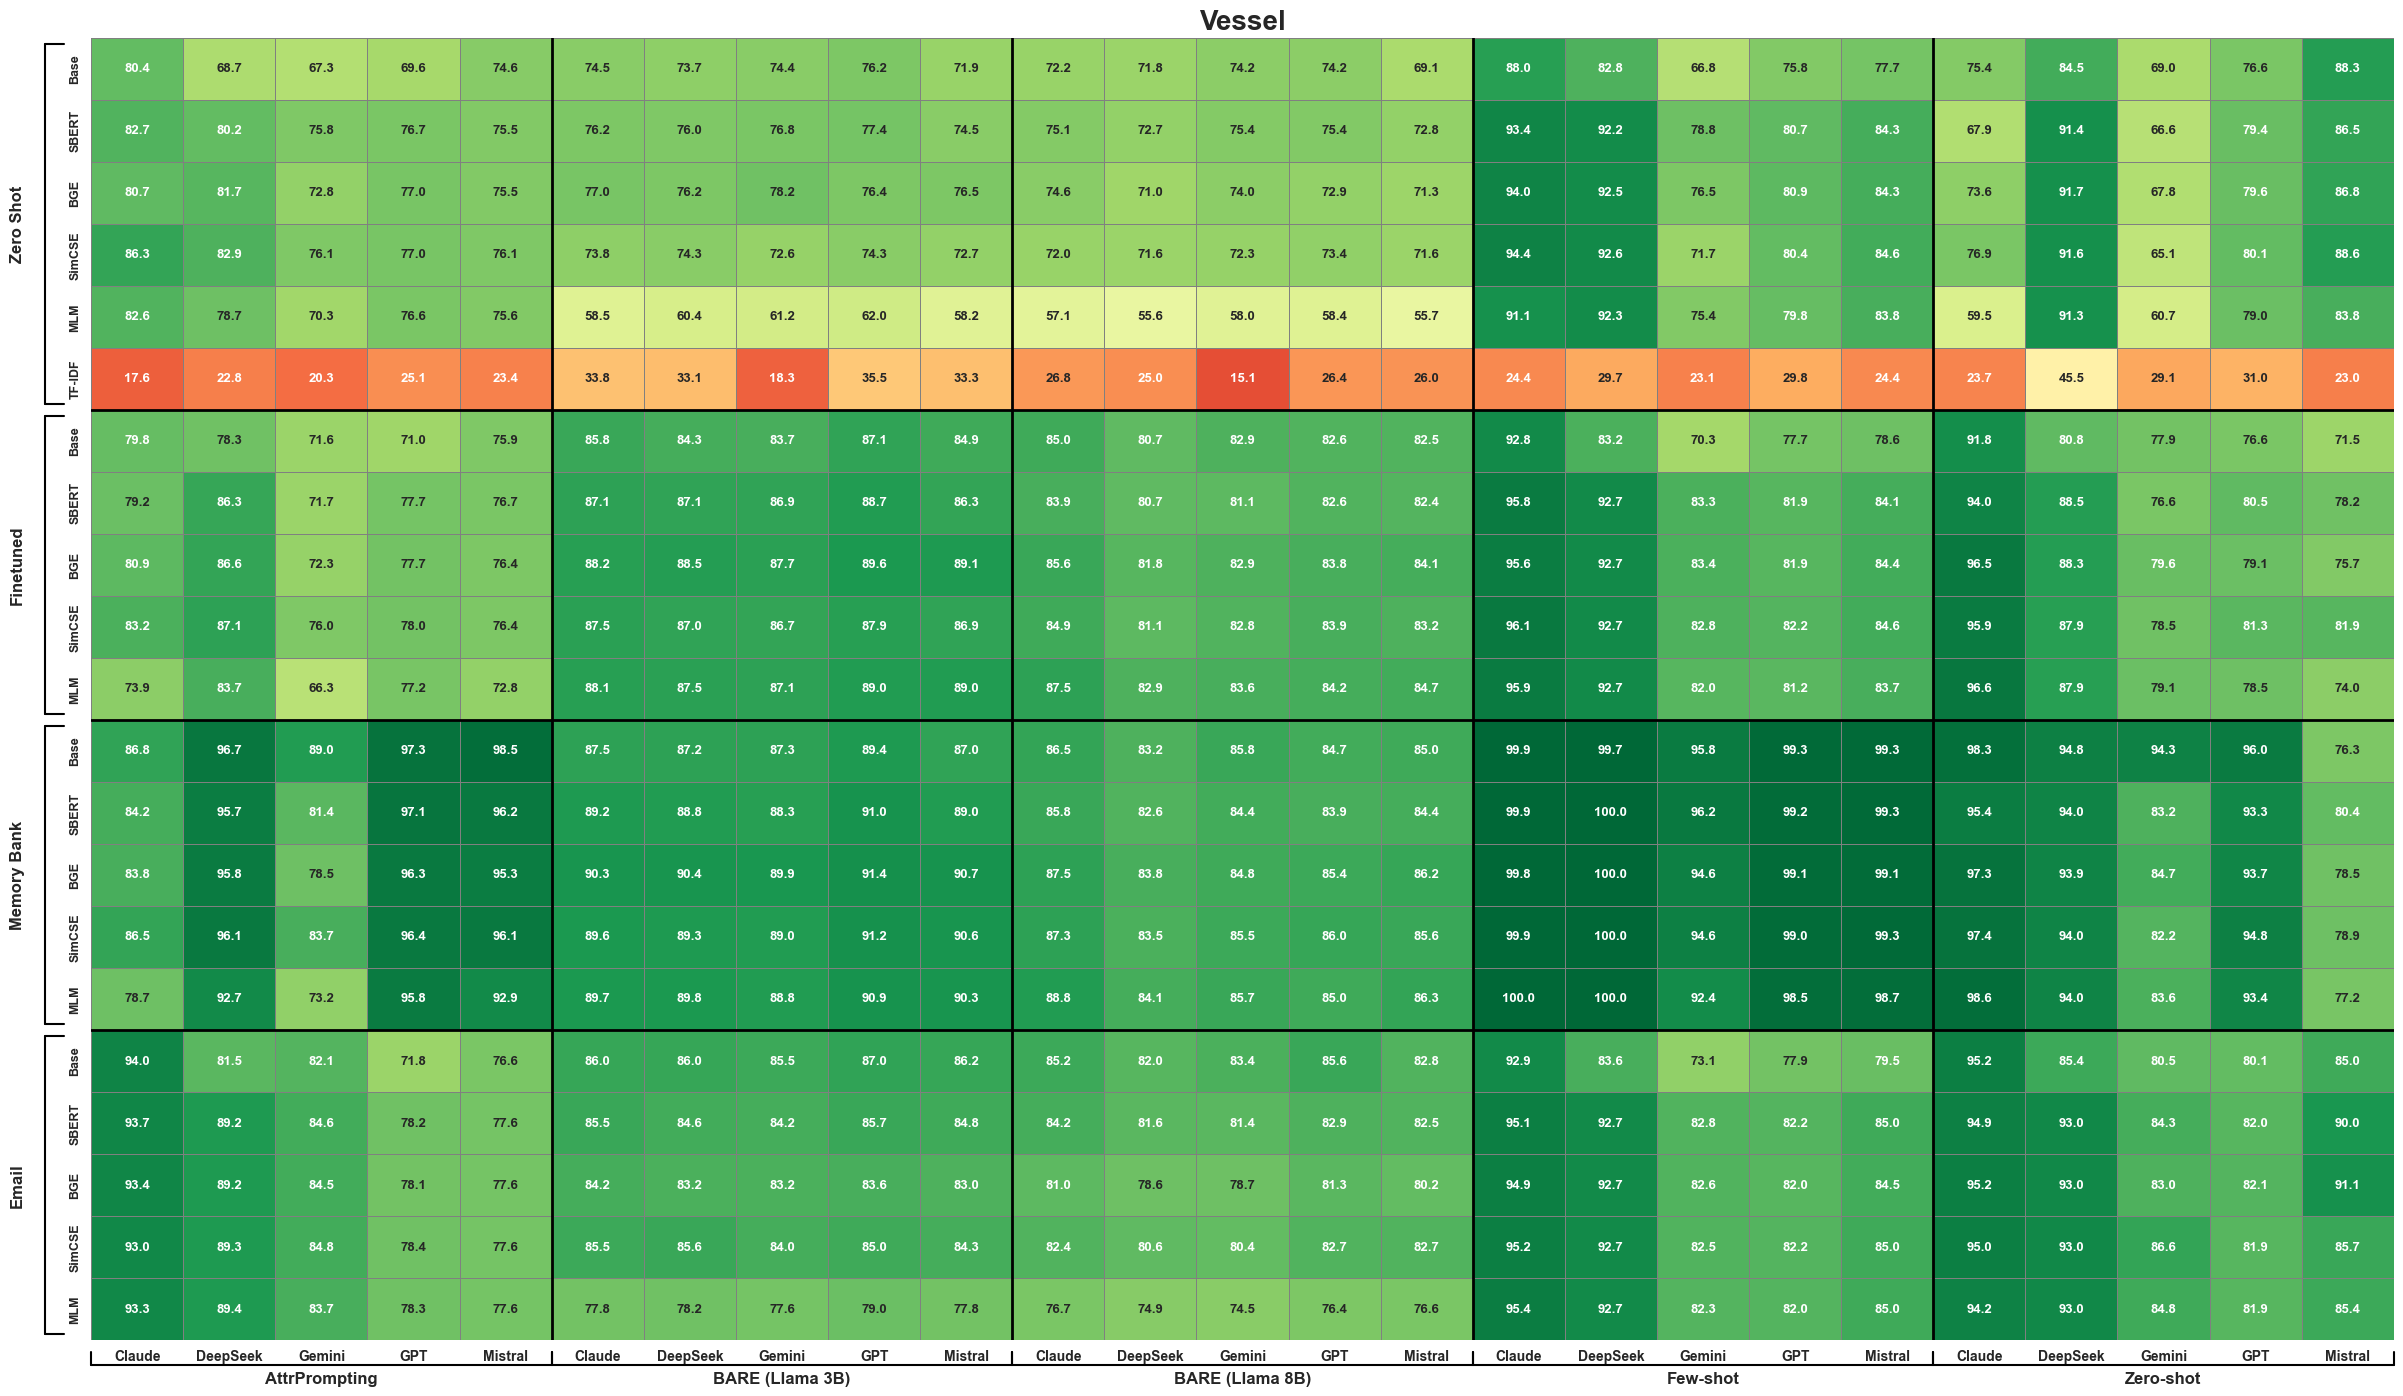


Creating combined heatmap for port...


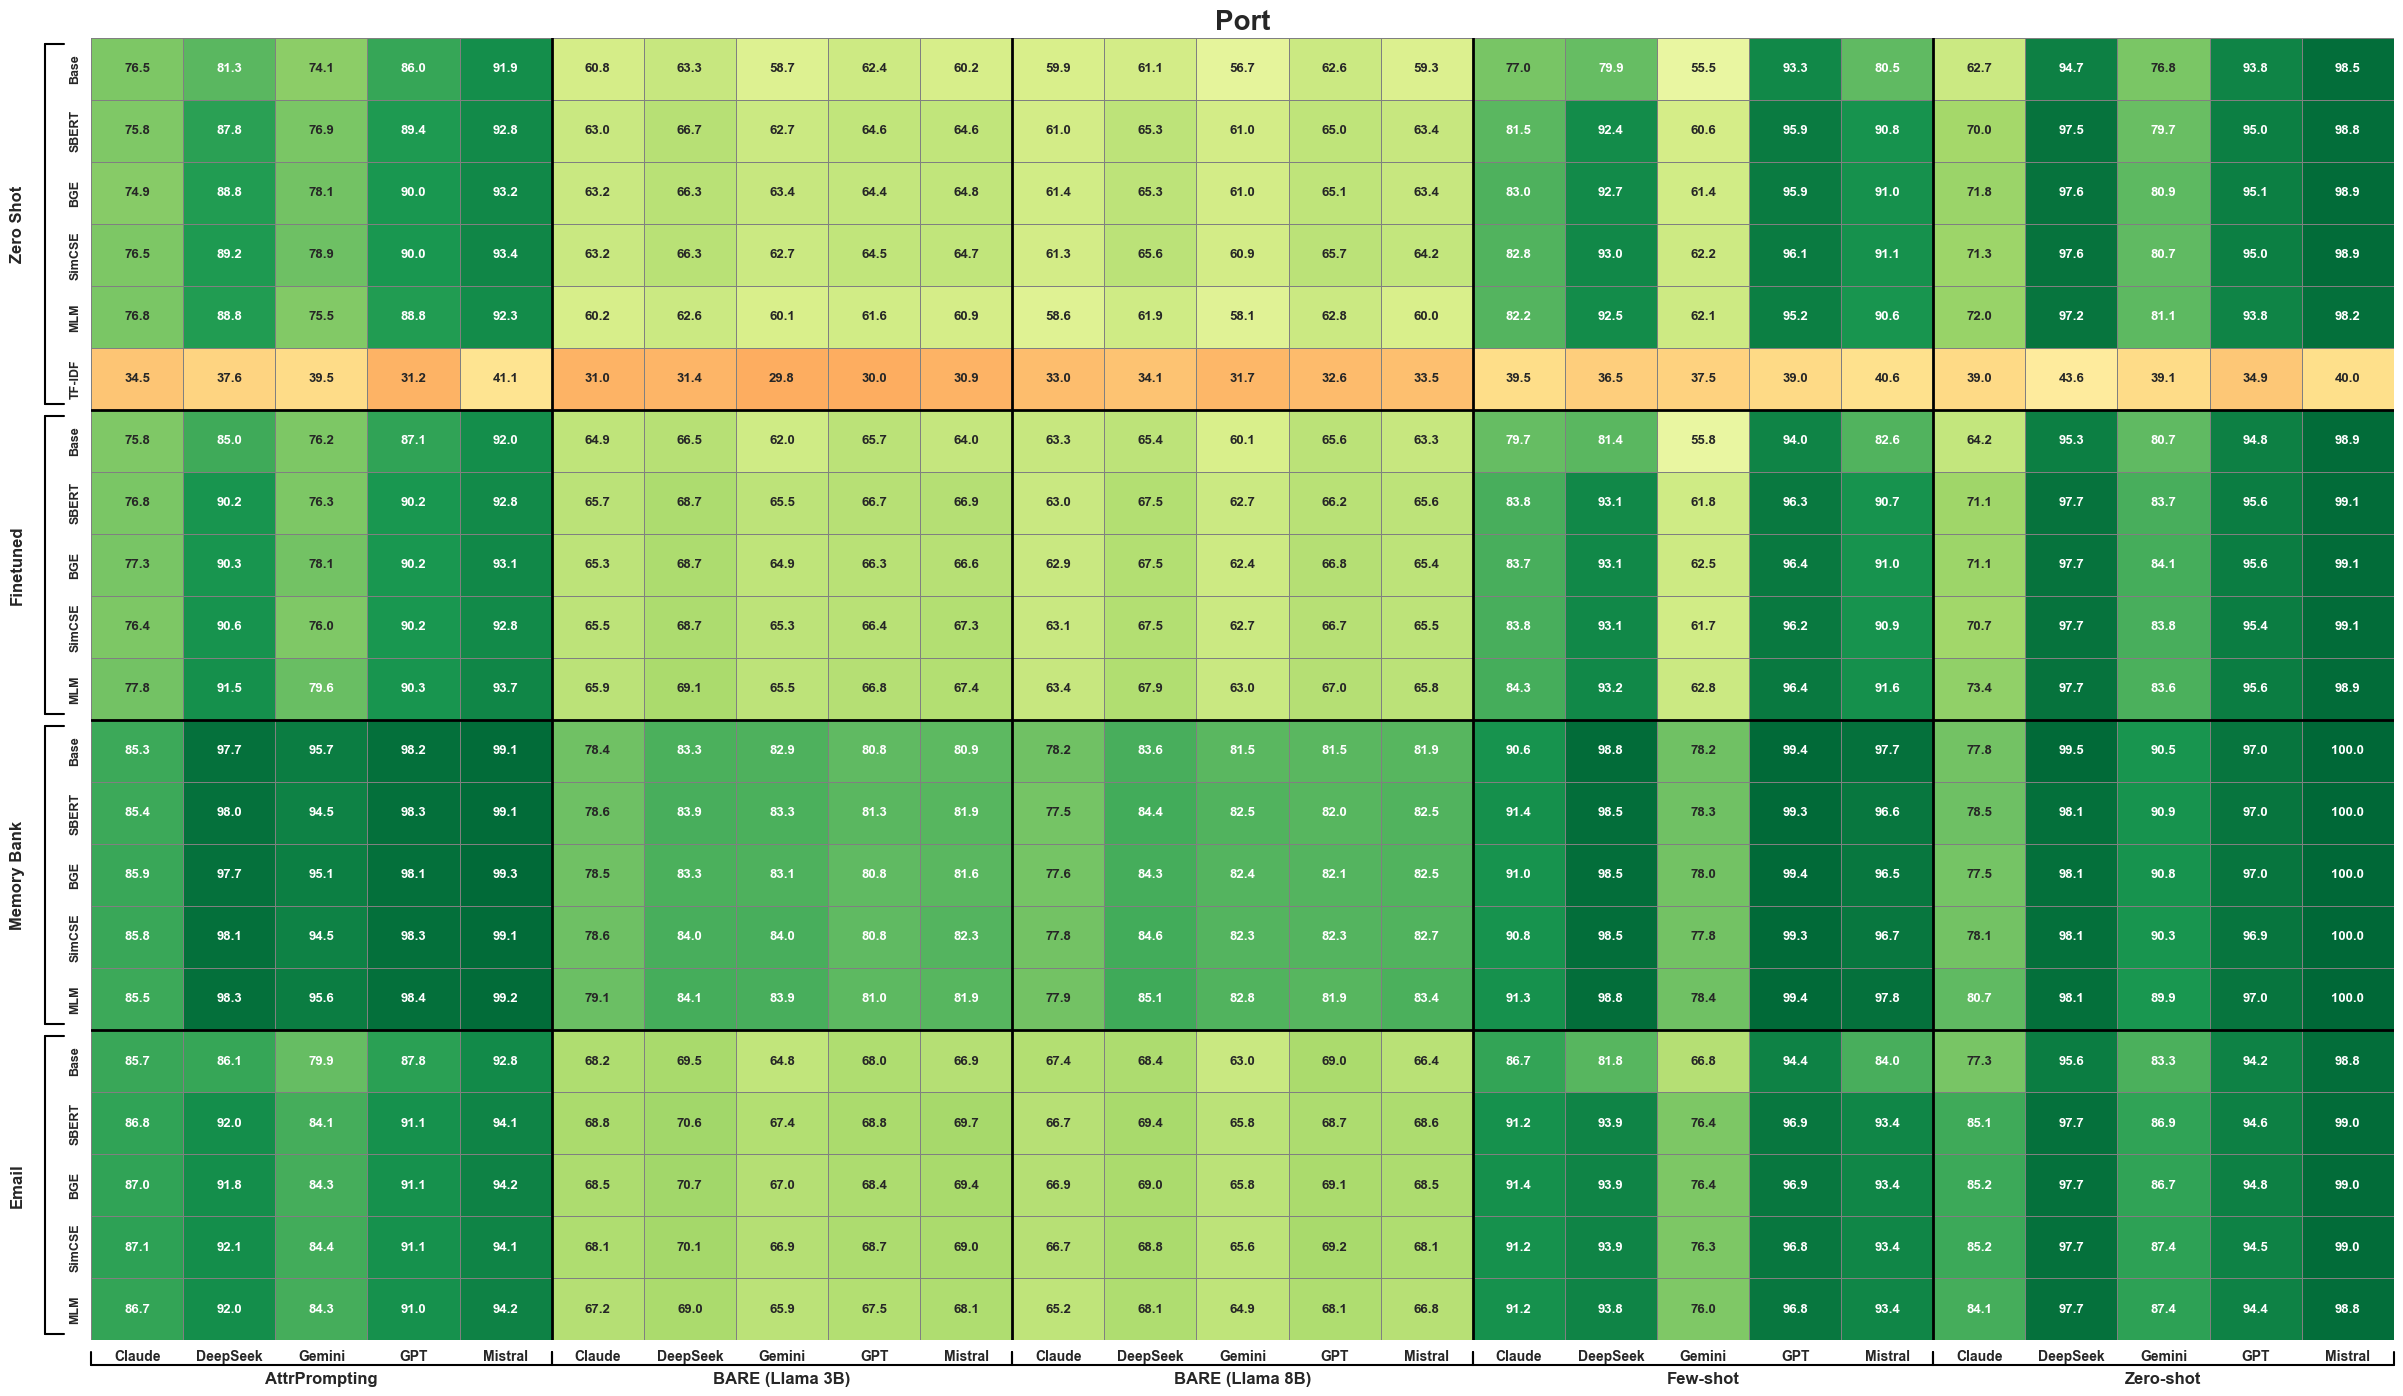


Creating combined heatmap for commodity...


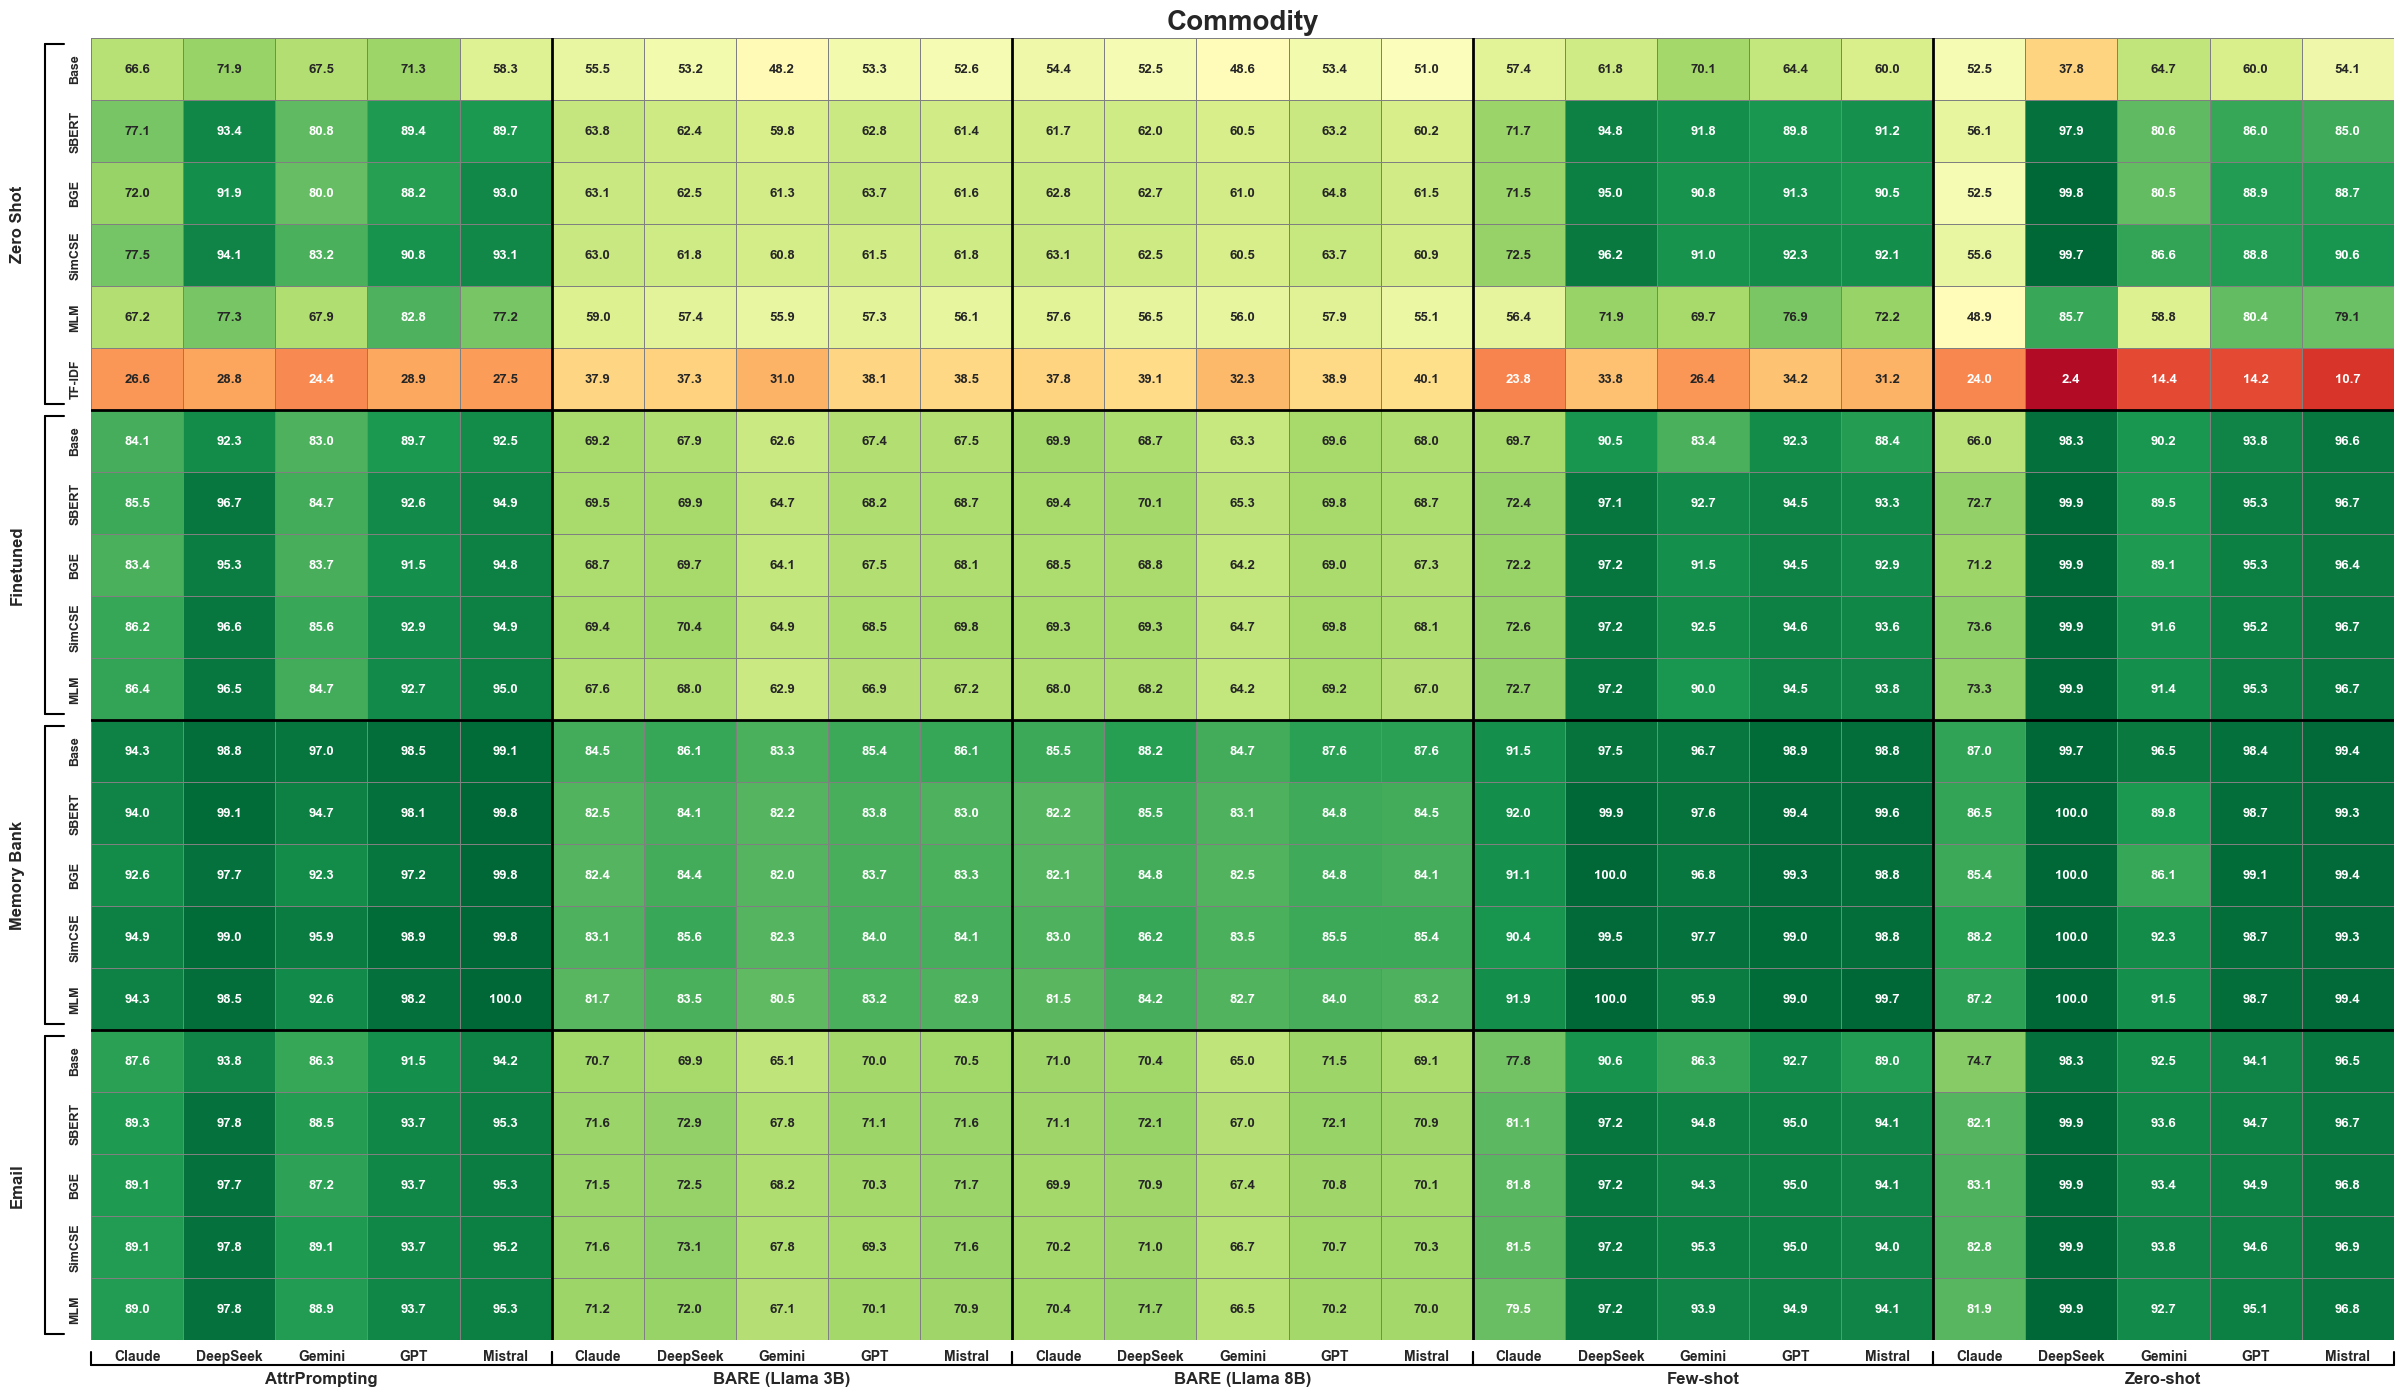


Creating combined heatmap for incoterm...


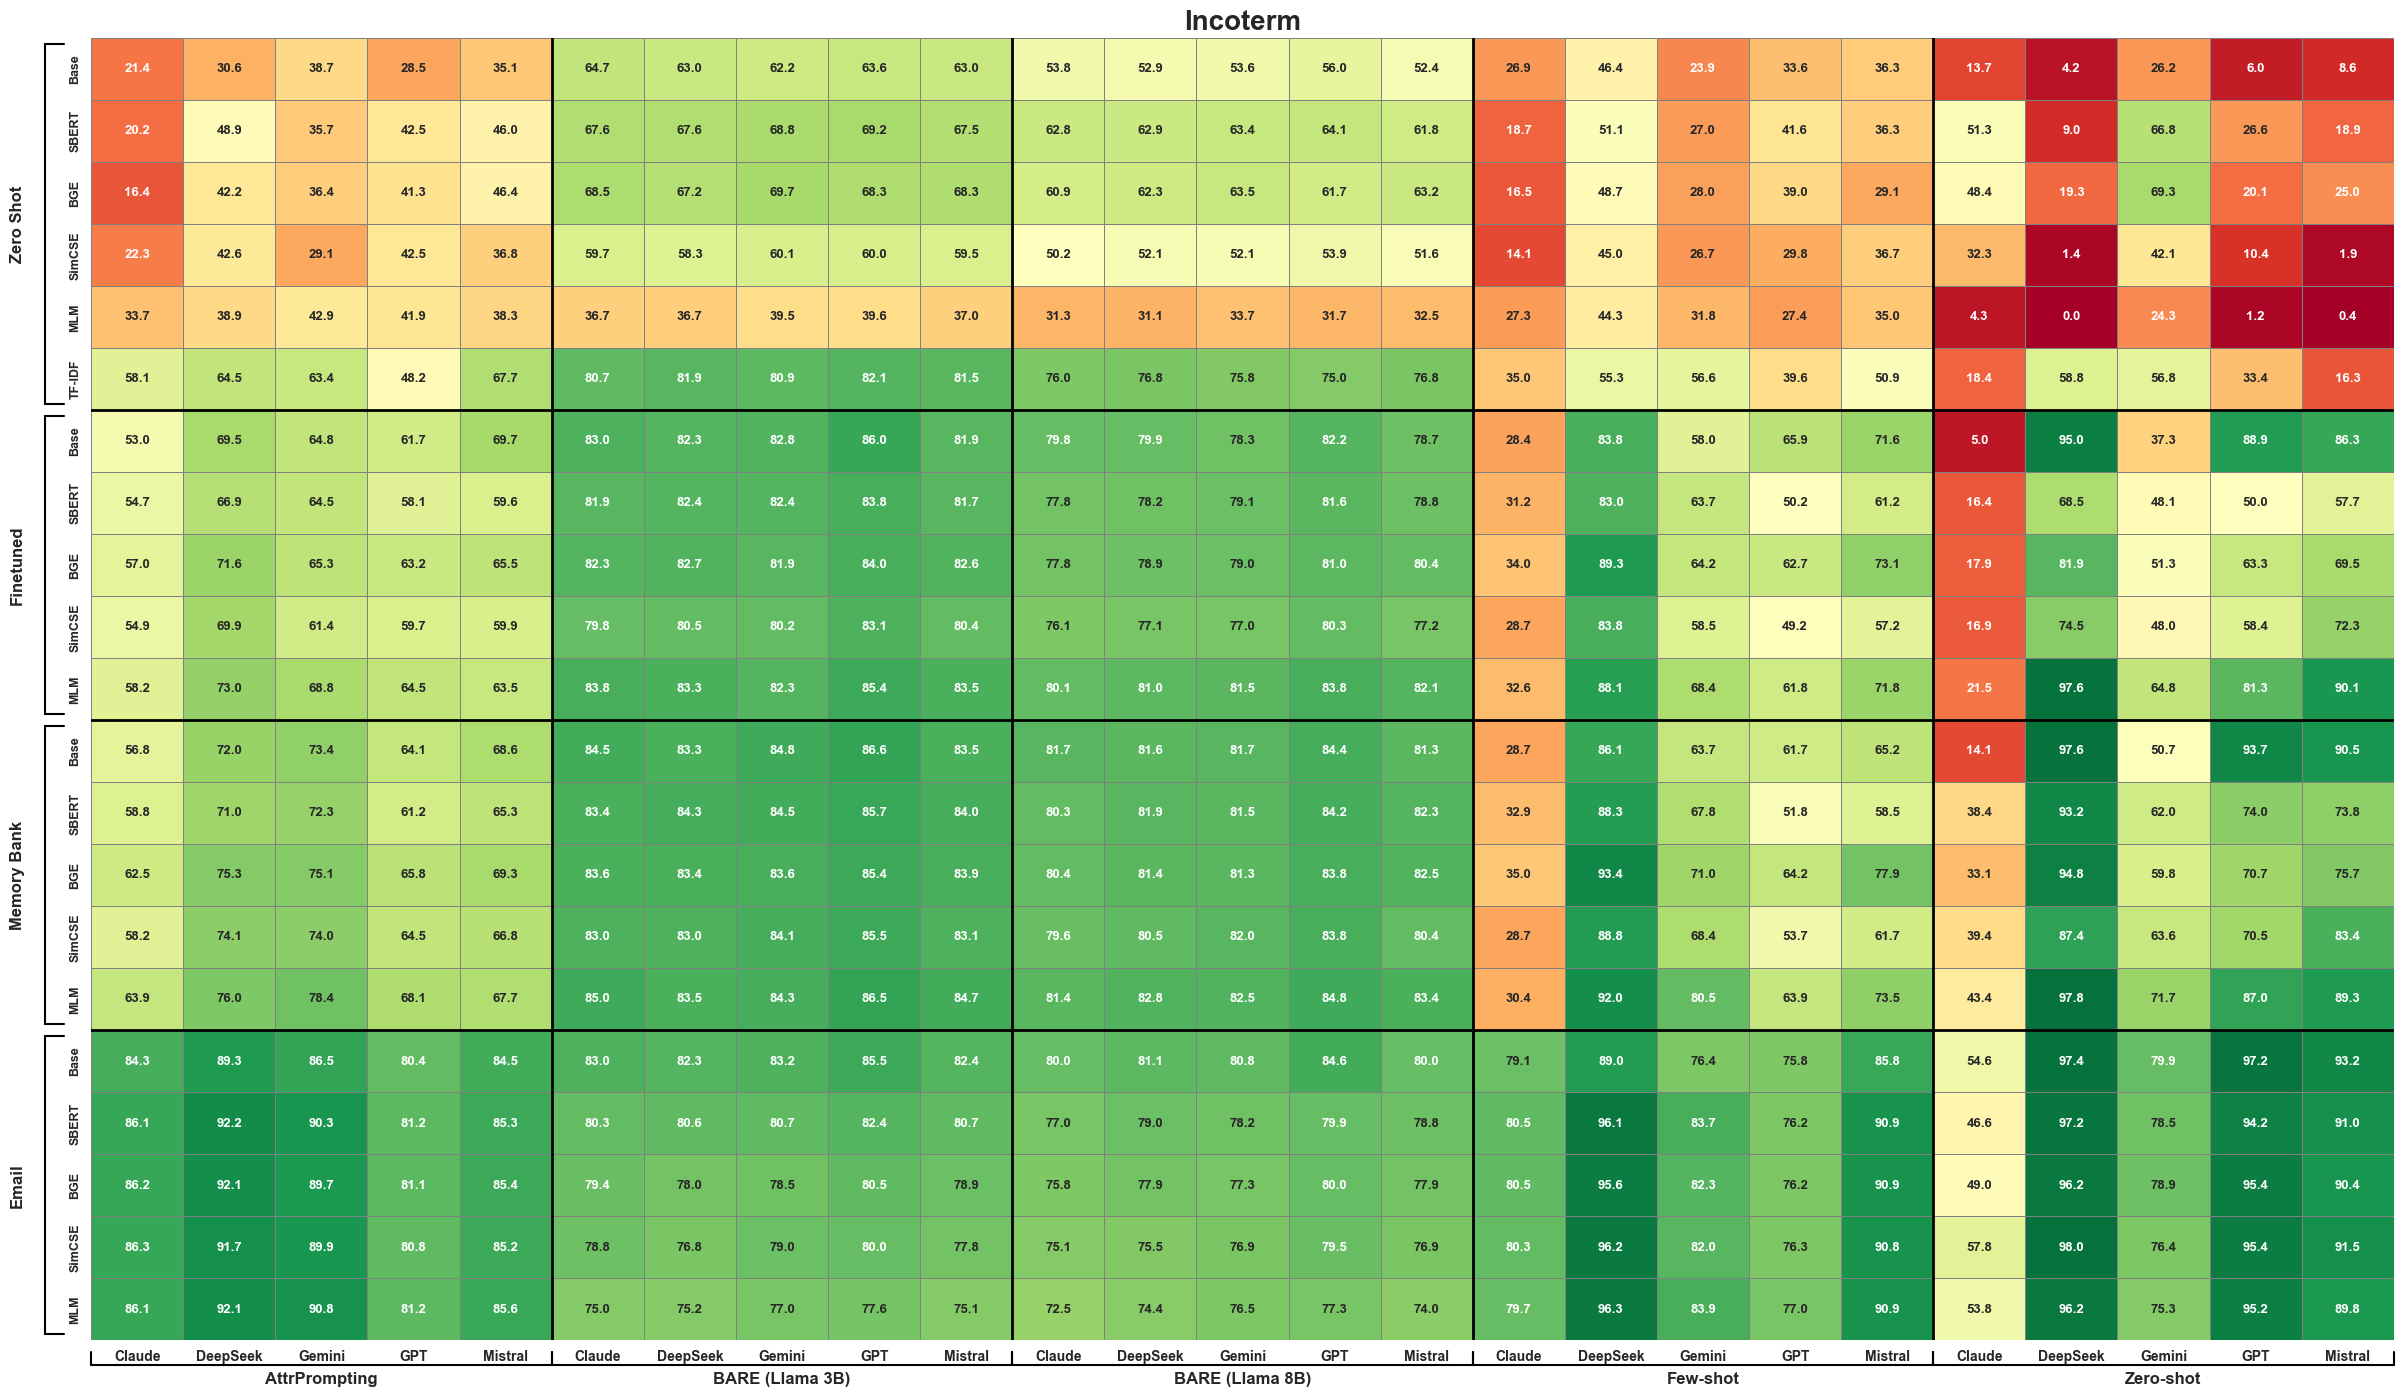

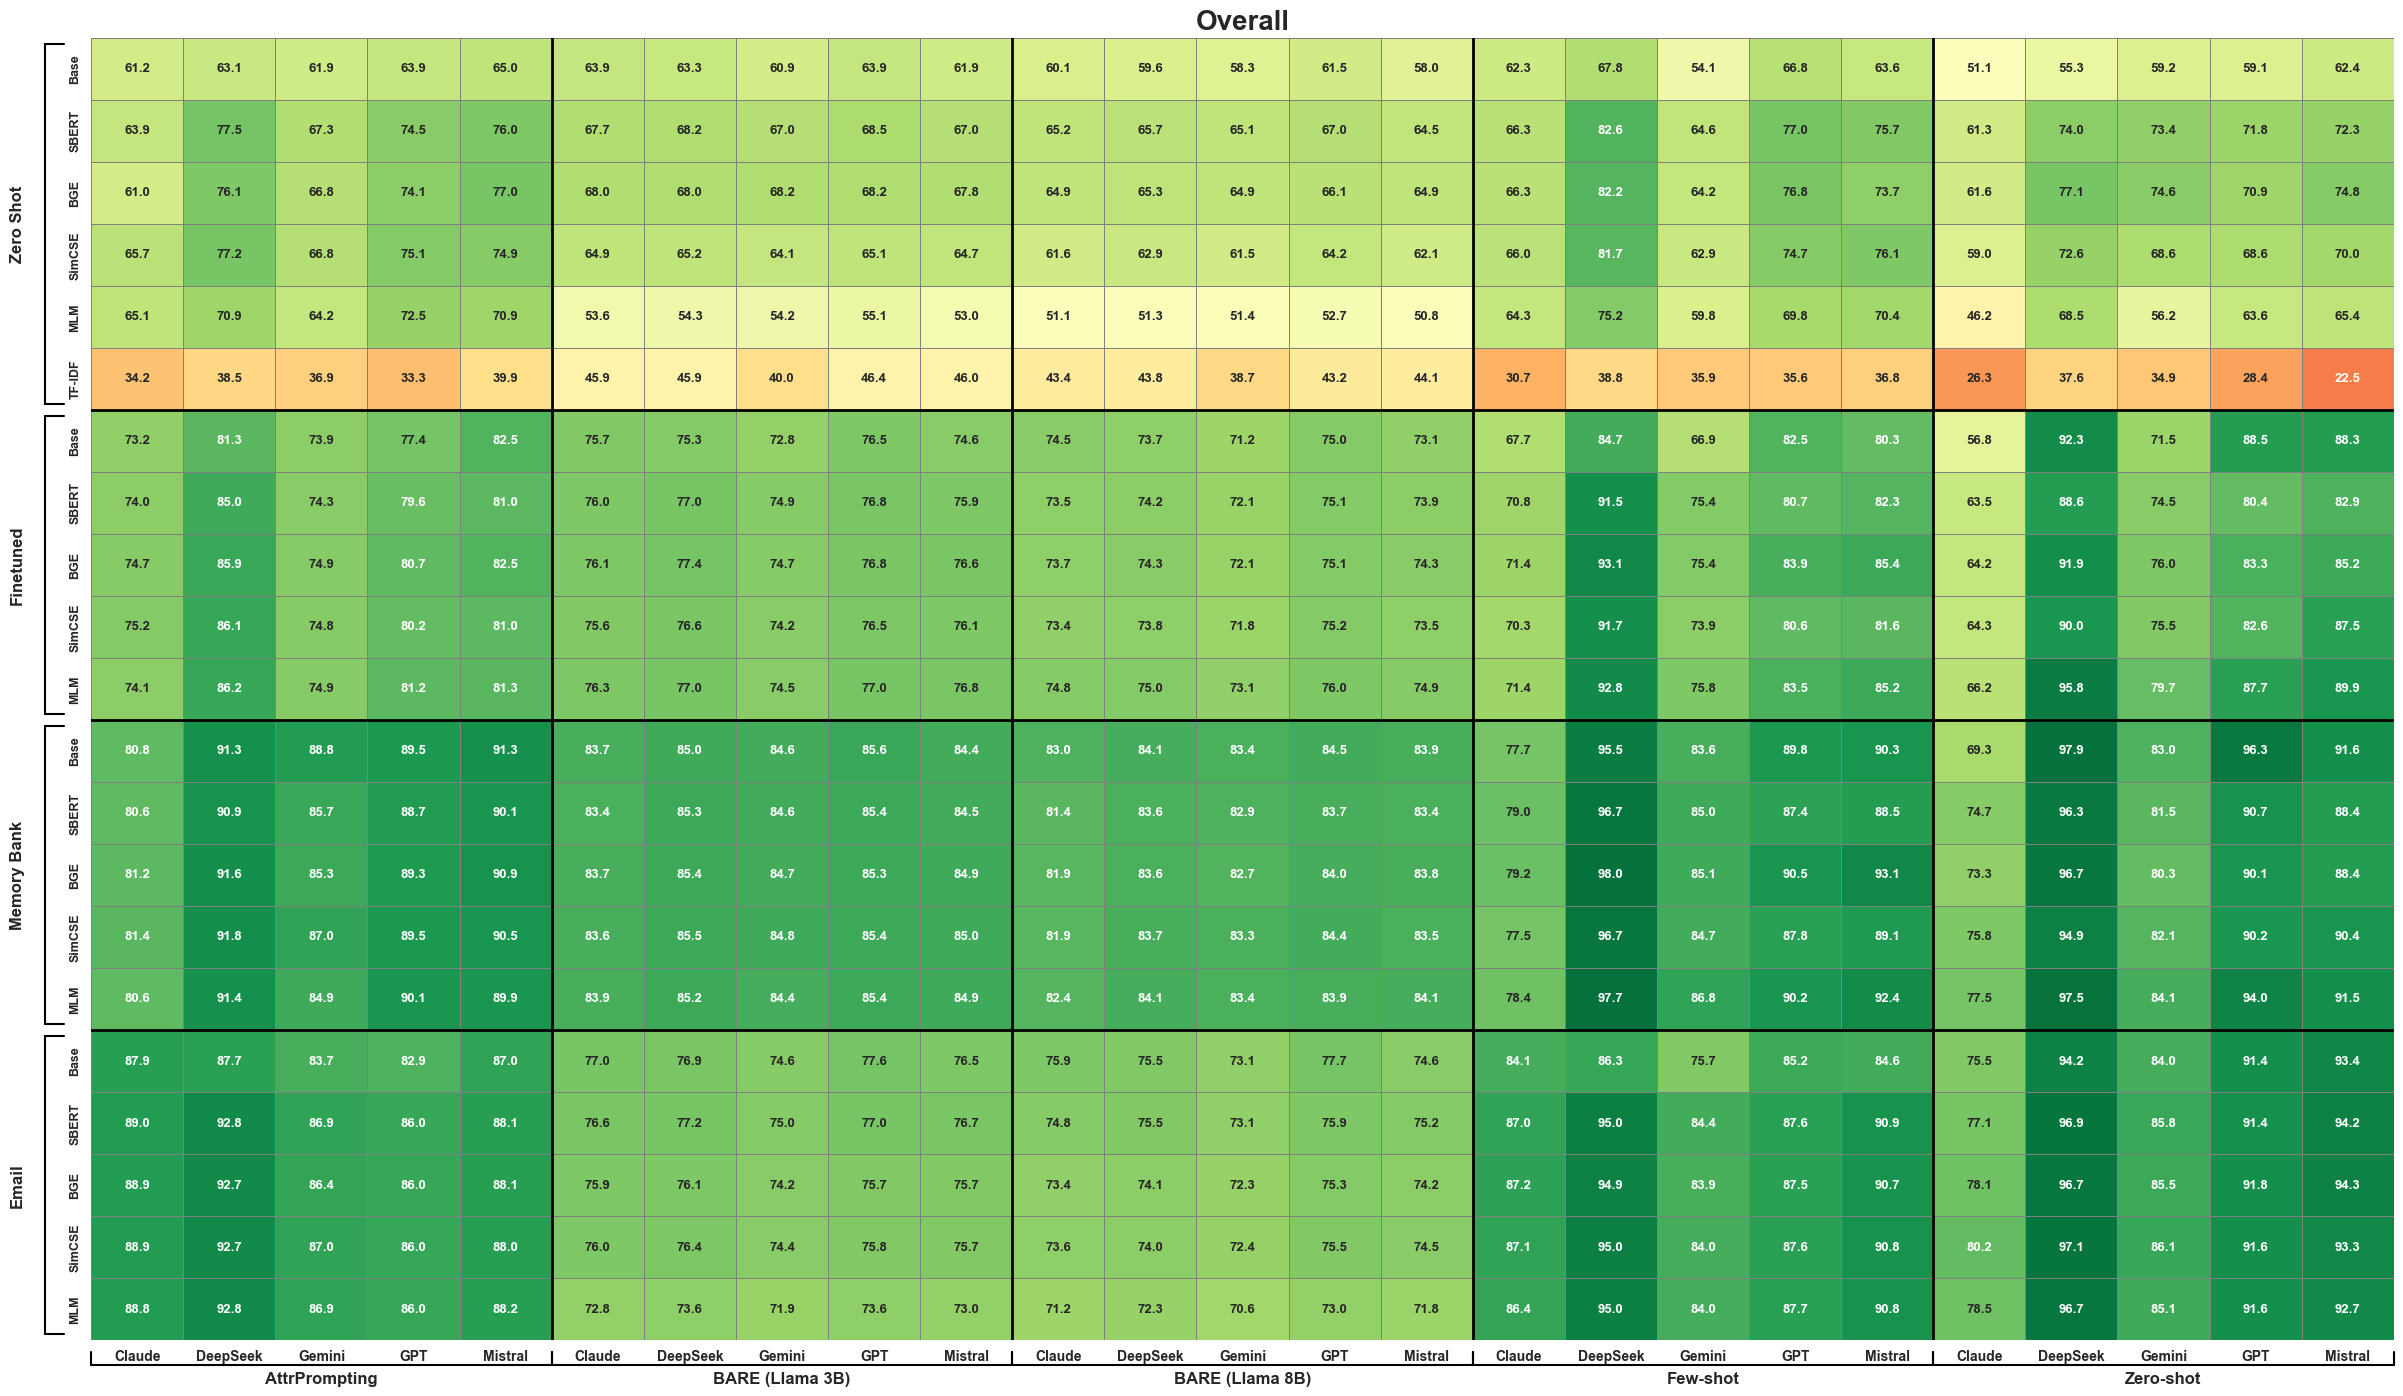

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# Data Reading
# -------------------------------------------------------------------
df = pd.read_csv(r'../gliner_evaluation/results/eval_gliner_tf_idf.csv')

# -------------------------------------------------------------------
# Model Groups
# -------------------------------------------------------------------
base_models = ['gliner_base',
               'gliner_sbert',
               'gliner_bge',
               'gliner_simcse',
               'gliner_mlm',
               'rule_based_tfidf']

finetuned_models = ['gliner_finetuned',
                    'gliner_finetued_sbert',
                    'gliner_finetuned_bge',
                    'gliner_finetuned_simcse',
                    'gliner_finetuned_mlm']

memory_bank_models = ['gliner_base_entity_aware',
                      'gliner_sbert_entity_aware',
                      'gliner_bge_entity_aware',
                      'gliner_simcse_entity_aware',
                      'gliner_mlm_entity_aware']

email_models = ['gliner_finetuned_email',
                'gliner_sbert_finetuned_email',
                'gliner_finetuned_bge_email',
                'gliner_finetuned_simcse_email',
                'gliner_finetuned_mlm_email']

# -------------------------------------------------------------------
# Model Renaming Dictionary
# -------------------------------------------------------------------
model_rename_dict = {

    # Base models
    'gliner_base': 'Base',
    'gliner_sbert': 'SBERT',
    'gliner_bge': 'BGE',
    'gliner_simcse': 'SimCSE',
    'gliner_mlm': 'MLM',
    'rule_based_tfidf': 'TF-IDF',

    # Finetuned models
    'gliner_finetuned': 'Base',
    'gliner_finetued_sbert': 'SBERT',
    'gliner_finetuned_sbert': 'SBERT',
    'gliner_finetuned_bge': 'BGE',
    'gliner_finetuned_simcse': 'SimCSE',
    'gliner_finetuned_mlm': 'MLM',

    # Memory bank models
    'gliner_base_entity_aware': 'Base',
    'gliner_sbert_entity_aware': 'SBERT',
    'gliner_bge_entity_aware': 'BGE',
    'gliner_simcse_entity_aware': 'SimCSE',
    'gliner_mlm_entity_aware': 'MLM',

    # Email finetuned models
    'gliner_finetuned_email': 'Base',
    'gliner_sbert_finetuned_email': 'SBERT',
    'gliner_finetuned_bge_email': 'BGE',
    'gliner_finetuned_simcse_email': 'SimCSE',
    'gliner_finetuned_mlm_email': 'MLM'
}

entity_types = ['vessel', 'port', 'commodity', 'incoterm']
all_datasets = sorted(df['dataset'].unique())

# -------------------------------------------------------------------
# Parsing Dataset Names
# -------------------------------------------------------------------
def parse_dataset_info(dataset_name):
    """Parse dataset name to extract generation type and model"""
    parts = dataset_name.split('_')

    if 'attr_prompting' in dataset_name:
        gen_type = 'AttrPrompting'
        model_name = parts[-1]

    elif 'bare_llama_3b' in dataset_name:
        gen_type = 'BARE (Llama 3B)'
        model_name = parts[-1]

    elif 'bare_llama_8b' in dataset_name:
        gen_type = 'BARE (Llama 8B)'
        model_name = parts[-1]

    elif 'fewshot' in dataset_name:
        gen_type = 'Few-shot'
        model_name = parts[-1]

    elif 'zeroshot' in dataset_name:
        gen_type = 'Zero-shot'
        model_name = parts[-1]

    else:
        gen_type = 'Unknown'
        model_name = dataset_name

    if model_name.lower() == 'gpt':
        model = 'GPT'

    elif model_name.lower() == 'deepseek':
        model = 'DeepSeek'

    else:
        model = model_name.capitalize()

    return gen_type, model

# -------------------------------------------------------------------
# Computing Overall Accuracy
# -------------------------------------------------------------------
def calculate_overall_accuracy(df, model, dataset):
    """Calculate overall accuracy across all entity types"""
    mask = (df['model'] == model) & (df['dataset'] == dataset)
    if mask.any():
        accuracies = []
        for entity in entity_types:
            acc = df.loc[mask, f'{entity}_f1'].values[0]
            accuracies.append(acc)
        return np.mean(accuracies)
    return np.nan

print("Calculating global minimum accuracy...")
global_min = 100.0
for entity in entity_types:
    for model in base_models + finetuned_models + memory_bank_models + email_models:
        if model in df['model'].values:
            for dataset in all_datasets:
                mask = (df['model'] == model) & (df['dataset'] == dataset)
                if mask.any():
                    accuracy = df.loc[mask, f'{entity}_f1'].values[0] * 100
                    if accuracy < global_min:
                        global_min = accuracy

print(f"Global minimum f1: {global_min:.1f}%")

# -------------------------------------------------------------------
# Individual Entity Heatmaps
# -------------------------------------------------------------------
for entity in entity_types:
    print(f"\nCreating combined heatmap for {entity}...")

    fig, ax = plt.subplots(figsize=(24, 14))

    all_data = []
    all_model_names = []
    model_groups = []

    for group_name, model_list in [('Zero Shot', base_models),
                                   ('Finetuned', finetuned_models),
                                   ('Memory Bank', memory_bank_models),
                                   ('Email', email_models)]:
        for model in model_list:
            if model in df['model'].values:
                renamed_model = model_rename_dict.get(model, model.replace('gliner_', '').replace('_', ' '))
                all_model_names.append(renamed_model)
                model_groups.append(group_name)
                row_data = []
                for dataset in all_datasets:
                    mask = (df['model'] == model) & (df['dataset'] == dataset)
                    if mask.any():
                        accuracy = df.loc[mask, f'{entity}_f1'].values[0]
                        row_data.append(accuracy * 100)
                    else:
                        row_data.append(np.nan)
                all_data.append(row_data)

    combined_df = pd.DataFrame(all_data, columns=all_datasets, index=all_model_names)

    dataset_info = [parse_dataset_info(d) for d in all_datasets]
    generation_types = [info[0] for info in dataset_info]
    model_names = [info[1] for info in dataset_info]

    sns.heatmap(combined_df,
               ax=ax,
               cmap='RdYlGn',
               vmin=global_min,
               vmax=100.0,
               annot=True,
               fmt='.1f',
               cbar=False,
               linewidths=0.5,
               linecolor='gray',
               annot_kws={'size': 9.5, 'fontweight': 'bold'})

    base_count = sum(1 for g in model_groups if g == 'Zero Shot')
    regular_finetuned_count = sum(1 for g in model_groups if g == 'Finetuned')
    memory_bank_count = sum(1 for g in model_groups if g == 'Memory Bank')
    email_count = sum(1 for g in model_groups if g == 'Email')

    if base_count > 0:
        ax.axhline(y=base_count, color='black', linewidth=2)
    if regular_finetuned_count > 0:
        ax.axhline(y=base_count + regular_finetuned_count, color='black', linewidth=2)
    if memory_bank_count > 0:
        ax.axhline(y=base_count + regular_finetuned_count + memory_bank_count, color='black', linewidth=2)

    category_info = []
    current_y = 0

    if base_count > 0:
        category_info.append(('Zero Shot', current_y, current_y + base_count - 1))
        current_y += base_count

    if regular_finetuned_count > 0:
        category_info.append(('Finetuned', current_y, current_y + regular_finetuned_count - 1))
        current_y += regular_finetuned_count

    if memory_bank_count > 0:
        category_info.append(('Memory Bank', current_y, current_y + memory_bank_count - 1))
        current_y += memory_bank_count

    if email_count > 0:
        category_info.append(('Email', current_y, current_y + email_count - 1))

    for category, start, end in category_info:
        center = (start + end) / 2 + 0.5
        ax.text(-0.8, center, category, ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)

        bracket_x = -0.3
        ax.plot([bracket_x, bracket_x - 0.2], [start + 0.1, start + 0.1], 'k-', transform=ax.transData, clip_on=False)
        ax.plot([bracket_x, bracket_x - 0.2], [end + 0.9, end + 0.9], 'k-', transform=ax.transData, clip_on=False)
        ax.plot([bracket_x - 0.2, bracket_x - 0.2], [start + 0.1, end + 0.9], 'k-', transform=ax.transData, clip_on=False)

    ax.set_xticklabels(model_names, rotation=0, ha='center', fontsize=10, fontweight="bold")

    gen_type_groups = []
    current_type = generation_types[0]
    start_idx = 0

    for i, gen_type in enumerate(generation_types + ['END']):
        if i == len(generation_types) or gen_type != current_type:
            gen_type_groups.append((current_type, start_idx, i-1))
            if i < len(generation_types):
                current_type = gen_type
                start_idx = i

    for i, (gen_type, start, end) in enumerate(gen_type_groups[1:], 1):
        ax.axvline(x=start, color='black', linewidth=2)

    for gen_type, start, end in gen_type_groups:
        center = (start + end) / 2
        ax.text(center + 0.5, len(combined_df) + 0.5, gen_type,
                ha='center', va='top', fontsize=12, fontweight='bold',
                transform=ax.transData)

        if end > start:
            ax.plot([start, start], [len(combined_df) + 0.2, len(combined_df) + 0.4],
                   'k-', transform=ax.transData, clip_on=False)
            ax.plot([end + 1, end + 1], [len(combined_df) + 0.2, len(combined_df) + 0.4],
                   'k-', transform=ax.transData, clip_on=False)
            ax.plot([start, end + 1], [len(combined_df) + 0.4, len(combined_df) + 0.4],
                   'k-', transform=ax.transData, clip_on=False)

    ax.set_title(f'{entity.capitalize()}', fontsize=20, fontweight='bold')
    ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9, fontweight="bold")

    plt.subplots_adjust(bottom=0.15, left=0.12)

    plt.tight_layout()
    plt.savefig(f'combined_heatmap_{entity}_clean.png', dpi=300, bbox_inches='tight')
    plt.show()

# -------------------------------------------------------------------
# Overall Heatmaps
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(24, 14))

all_data = []
all_model_names = []
model_groups = []

for group_name, model_list in [('Zero Shot', base_models),
                               ('Finetuned', finetuned_models),
                               ('Memory Bank', memory_bank_models),
                               ('Email', email_models)]:
    for model in model_list:
        if model in df['model'].values:
            renamed_model = model_rename_dict.get(model, model.replace('gliner_', '').replace('_', ' '))
            all_model_names.append(renamed_model)
            model_groups.append(group_name)
            row_data = []
            for dataset in all_datasets:
                overall_acc = calculate_overall_accuracy(df, model, dataset)
                if not np.isnan(overall_acc):
                    row_data.append(overall_acc * 100)
                else:
                    row_data.append(np.nan)
            all_data.append(row_data)

combined_df = pd.DataFrame(all_data, columns=all_datasets, index=all_model_names)

dataset_info = [parse_dataset_info(d) for d in all_datasets]
generation_types = [info[0] for info in dataset_info]
model_names = [info[1] for info in dataset_info]

sns.heatmap(combined_df,
           ax=ax,
           cmap='RdYlGn',
           vmin=global_min,
           vmax=100.0,
           annot=True,
           fmt='.1f',
           cbar=False,
           linewidths=0.5,
           linecolor='gray',
           annot_kws={'size': 9.5, 'fontweight': 'bold'})

base_count = sum(1 for g in model_groups if g == 'Zero Shot')
regular_finetuned_count = sum(1 for g in model_groups if g == 'Finetuned')
memory_bank_count = sum(1 for g in model_groups if g == 'Memory Bank')
email_count = sum(1 for g in model_groups if g == 'Email')

if base_count > 0:
    ax.axhline(y=base_count, color='black', linewidth=2)
if regular_finetuned_count > 0:
    ax.axhline(y=base_count + regular_finetuned_count, color='black', linewidth=2)
if memory_bank_count > 0:
    ax.axhline(y=base_count + regular_finetuned_count + memory_bank_count, color='black', linewidth=2)

category_info = []
current_y = 0

if base_count > 0:
    category_info.append(('Zero Shot', current_y, current_y + base_count - 1))
    current_y += base_count

if regular_finetuned_count > 0:
    category_info.append(('Finetuned', current_y, current_y + regular_finetuned_count - 1))
    current_y += regular_finetuned_count

if memory_bank_count > 0:
    category_info.append(('Memory Bank', current_y, current_y + memory_bank_count - 1))
    current_y += memory_bank_count

if email_count > 0:
    category_info.append(('Email', current_y, current_y + email_count - 1))

for category, start, end in category_info:
    center = (start + end) / 2 + 0.5
    ax.text(-0.8, center, category, ha='center', va='center', fontsize=12, fontweight='bold', rotation=90)

    bracket_x = -0.3
    ax.plot([bracket_x, bracket_x - 0.2], [start + 0.1, start + 0.1], 'k-', transform=ax.transData, clip_on=False)
    ax.plot([bracket_x, bracket_x - 0.2], [end + 0.9, end + 0.9], 'k-', transform=ax.transData, clip_on=False)
    ax.plot([bracket_x - 0.2, bracket_x - 0.2], [start + 0.1, end + 0.9], 'k-', transform=ax.transData, clip_on=False)

ax.set_xticklabels(model_names, rotation=0, ha='center', fontsize=10, fontweight="bold")

gen_type_groups = []
current_type = generation_types[0]
start_idx = 0

for i, gen_type in enumerate(generation_types + ['END']):
    if i == len(generation_types) or gen_type != current_type:
        gen_type_groups.append((current_type, start_idx, i-1))
        if i < len(generation_types):
            current_type = gen_type
            start_idx = i

for i, (gen_type, start, end) in enumerate(gen_type_groups[1:], 1):
    ax.axvline(x=start, color='black', linewidth=2)

for gen_type, start, end in gen_type_groups:
    center = (start + end) / 2
    ax.text(center + 0.5, len(combined_df) + 0.5, gen_type,
            ha='center', va='top', fontsize=12, fontweight='bold',
            transform=ax.transData)

    if end > start:
        ax.plot([start, start], [len(combined_df) + 0.2, len(combined_df) + 0.4],
               'k-', transform=ax.transData, clip_on=False)
        ax.plot([end + 1, end + 1], [len(combined_df) + 0.2, len(combined_df) + 0.4],
               'k-', transform=ax.transData, clip_on=False)
        ax.plot([start, end + 1], [len(combined_df) + 0.4, len(combined_df) + 0.4],
               'k-', transform=ax.transData, clip_on=False)

ax.set_title('Overall', fontsize=20, fontweight='bold')
ax.set_ylabel('')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9, fontweight="bold")

plt.subplots_adjust(bottom=0.15, left=0.12)

plt.tight_layout()
plt.savefig('combined_heatmap_overall_clean.png', dpi=300, bbox_inches='tight')
plt.show()

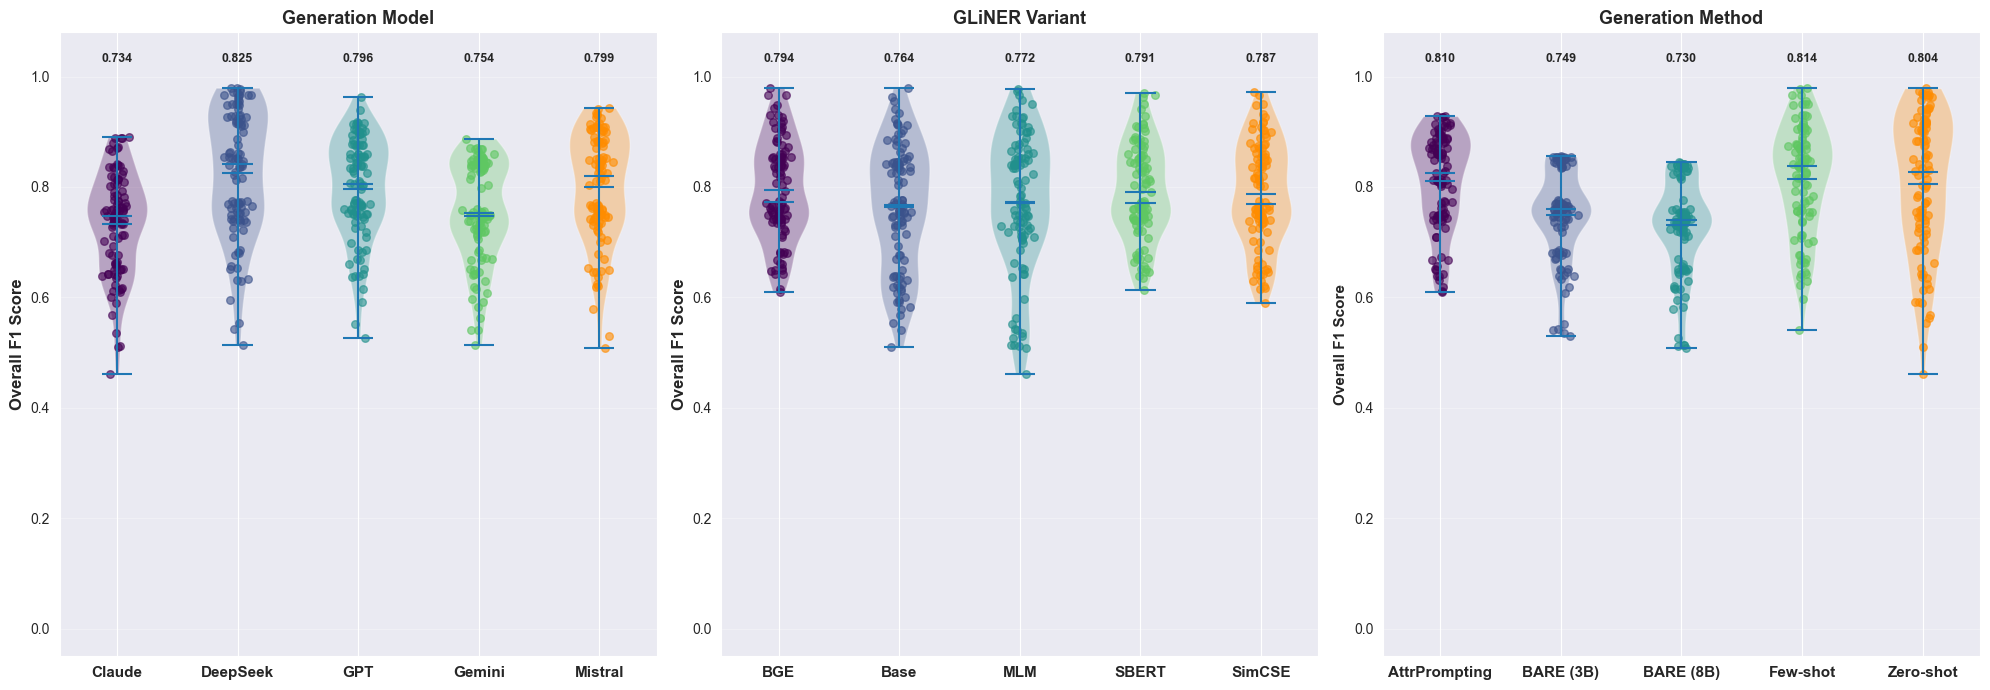

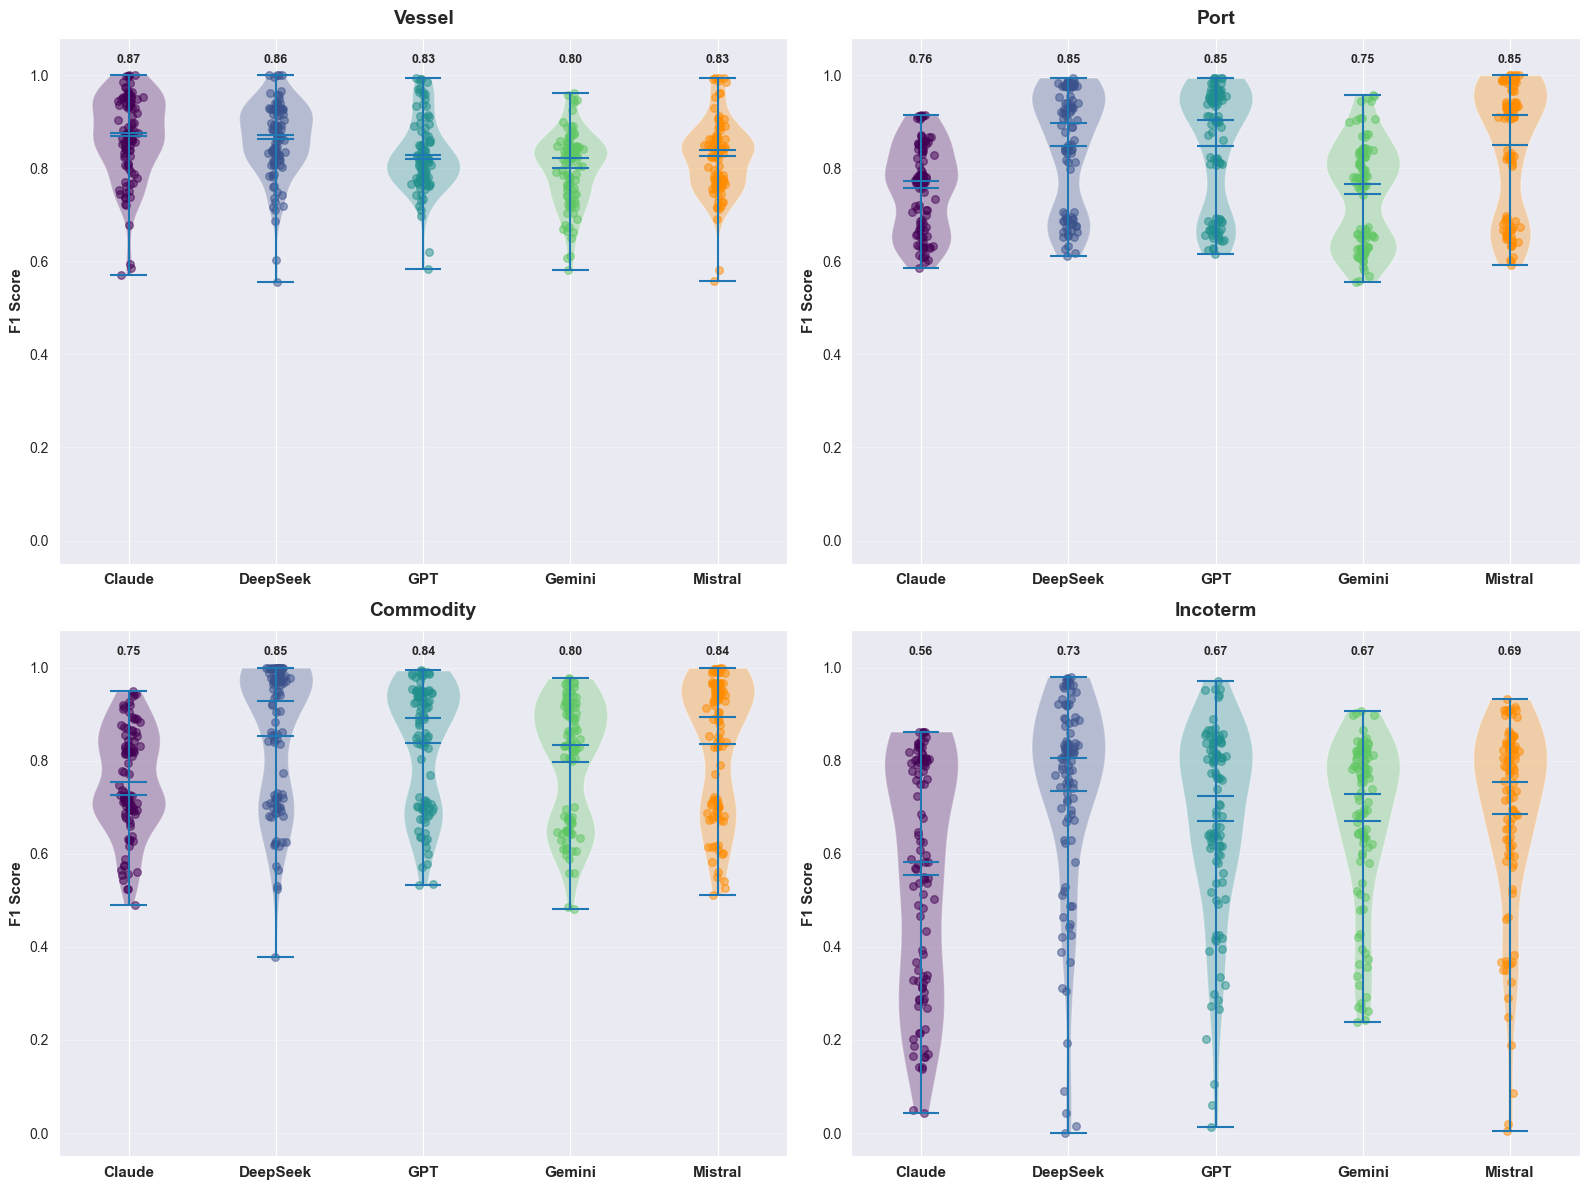

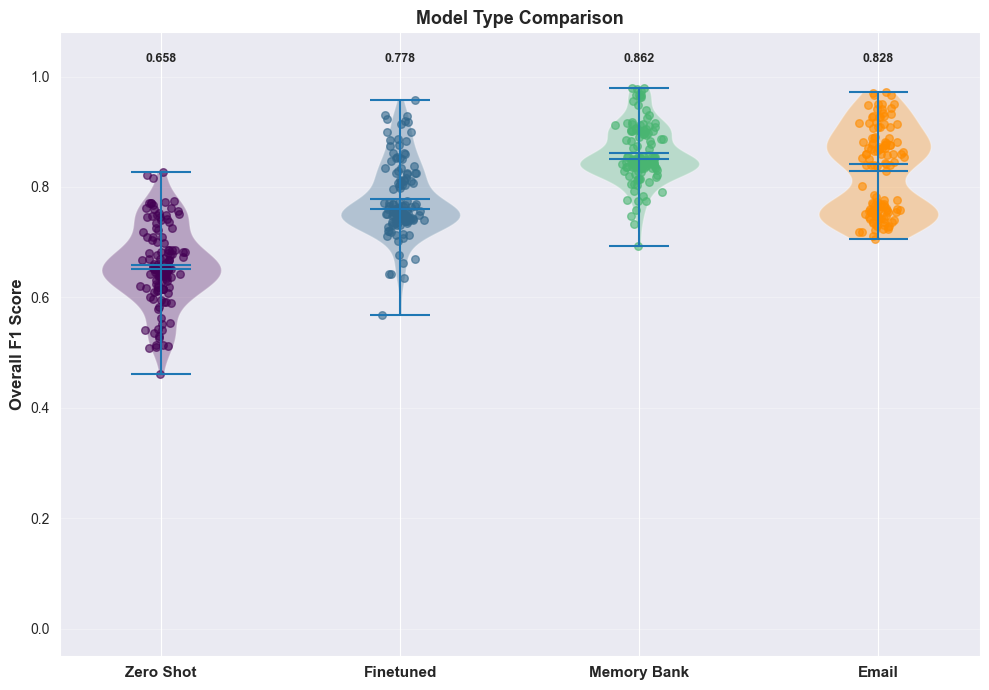

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import (viridis,
                           plasma)
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# Data Reading
# -------------------------------------------------------------------
df = pd.read_csv(r'C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\gliner_evaluation\gliner_eval_full.csv')

# -------------------------------------------------------------------
# Calculate Overall F1 Score
# -------------------------------------------------------------------
def calculate_overall_f1(row):
    """Calculate overall F1 as average of individual entity F1 scores"""
    entity_f1s = [row['vessel_f1'], row['port_f1'], row['commodity_f1'], row['incoterm_f1']]
    return np.mean(entity_f1s)

df['overall_f1'] = df.apply(calculate_overall_f1, axis=1)

# -------------------------------------------------------------------
# Extracting Generation Model
# -------------------------------------------------------------------
def extract_generation_model(dataset):
    if dataset.endswith('_gpt'):
        return 'GPT'

    elif dataset.endswith('_deepseek'):
        return 'DeepSeek'

    elif dataset.endswith('_gemini'):
        return 'Gemini'

    elif dataset.endswith('_claude'):
        return 'Claude'

    elif dataset.endswith('_mistral'):
        return 'Mistral'

    elif 'llama' in dataset:
        return 'Llama'

    else:
        return 'Unknown'

# -------------------------------------------------------------------
# Extraction Generation method
# -------------------------------------------------------------------
def extract_generation_method(dataset):
    if 'attr_prompting' in dataset:
        return 'AttrPrompting'

    elif 'bare_llama_3b' in dataset:
        return 'BARE (3B)'

    elif 'bare_llama_8b' in dataset:
        return 'BARE (8B)'

    elif 'fewshot' in dataset:
        return 'Few-shot'

    elif 'zeroshot' in dataset:
        return 'Zero-shot'

    return 'Unknown'

# -------------------------------------------------------------------
# Model Groups
# -------------------------------------------------------------------
base_models = ['gliner_base',
               'gliner_sbert',
               'gliner_bge',
               'gliner_simcse',
               'gliner_mlm',
               'rule_based_tfidf']

finetuned_models = ['gliner_finetuned',
                    'gliner_finetued_sbert',
                    'gliner_finetuned_bge',
                    'gliner_finetuned_simcse',
                    'gliner_finetuned_mlm']

memory_bank_models = ['gliner_base_entity_aware',
                      'gliner_sbert_entity_aware',
                      'gliner_bge_entity_aware',
                      'gliner_simcse_entity_aware',
                      'gliner_mlm_entity_aware']

email_models = ['gliner_finetuned_email',
                'gliner_sbert_finetuned_email',
                'gliner_finetuned_bge_email',
                'gliner_finetuned_simcse_email',
                'gliner_finetuned_mlm_email']

# -------------------------------------------------------------------
# Model Renaming Dictionary
# -------------------------------------------------------------------
model_rename_dict = {

    # Base models
    'gliner_base': 'Base',
    'gliner_sbert': 'SBERT',
    'gliner_bge': 'BGE',
    'gliner_simcse': 'SimCSE',
    'gliner_mlm': 'MLM',
    'rule_based_tfidf': 'TF-IDF',

    # Finetuned models
    'gliner_finetuned': 'Base',
    'gliner_finetued_sbert': 'SBERT',
    'gliner_finetuned_sbert': 'SBERT',
    'gliner_finetuned_bge': 'BGE',
    'gliner_finetuned_simcse': 'SimCSE',
    'gliner_finetuned_mlm': 'MLM',

    # Memory bank models
    'gliner_base_entity_aware': 'Base',
    'gliner_sbert_entity_aware': 'SBERT',
    'gliner_bge_entity_aware': 'BGE',
    'gliner_simcse_entity_aware': 'SimCSE',
    'gliner_mlm_entity_aware': 'MLM',

    # Email finetuned models
    'gliner_finetuned_email': 'Base',
    'gliner_sbert_finetuned_email': 'SBERT',
    'gliner_finetuned_bge_email': 'BGE',
    'gliner_finetuned_simcse_email': 'SimCSE',
    'gliner_finetuned_mlm_email': 'MLM'
}


df['generation_model'] = df['dataset'].apply(extract_generation_model)
df['generation_method'] = df['dataset'].apply(extract_generation_method)
df['gliner_variant'] = df['model'].map(model_rename_dict)

def get_model_type(model_name):
    if model_name in base_models:
        return 'Zero Shot'
    elif model_name in finetuned_models:
        return 'Finetuned'
    elif model_name in memory_bank_models:
        return 'Memory Bank'
    elif model_name in email_models:
        return 'Email'
    else:
        return 'Unknown'

df['model_type'] = df['model'].apply(get_model_type)

gen_model_order = sorted(df['generation_model'].unique())
gliner_variant_order = sorted(df['gliner_variant'].dropna().unique())
gen_method_order = sorted(df['generation_method'].unique())


def get_viridis_colors(n):
    """Get n evenly spaced colors from the viridis colormap"""
    return [viridis(i / (n - 1)) for i in range(n)]

def get_custom_colors(n):
    """Get n evenly spaced colors from purple to orange"""
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#fde725']  # Original viridis
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#ff8c00']  # Dark orange instead of yellow

    cmap = mcolors.LinearSegmentedColormap.from_list('purple_to_orange', colors)

    return [cmap(i / (n - 1)) for i in range(n)]


max_categories = max(len(gen_model_order), len(gliner_variant_order), len(gen_method_order))
base_colors = get_custom_colors(max_categories)


def get_custom_colors(n):
    """Get n evenly spaced colors from purple to orange"""
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#fde725']  # Original viridis
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#ff8c00']  # Dark orange instead of yellow

    cmap = mcolors.LinearSegmentedColormap.from_list('purple_to_orange', colors)

    return [cmap(i / (n - 1)) for i in range(n)]


# -------------------------------------------------------------------
# 1x3 Grid Plot - Generation Model | GLiNER Variant | Generation Method
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Generation Model
ax = axes[0]
models = gen_model_order
violin_data = [df[df['generation_model'] == model]['overall_f1'].values for model in models]
violin_parts = ax.violinplot(violin_data, positions=range(len(models)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, model in enumerate(models):
    data = df[df['generation_model'] == model]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Generation Model', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

# GLiNER Variant
ax = axes[1]
variants = gliner_variant_order
violin_data = [df[df['gliner_variant'] == variant]['overall_f1'].values for variant in variants]
violin_parts = ax.violinplot(violin_data, positions=range(len(variants)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, variant in enumerate(variants):
    data = df[df['gliner_variant'] == variant]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(variants)))
ax.set_xticklabels(variants, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('GLiNER Variant', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

# Generation Method
ax = axes[2]
methods = gen_method_order
violin_data = [df[df['generation_method'] == method]['overall_f1'].values for method in methods]
violin_parts = ax.violinplot(violin_data, positions=range(len(methods)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.3)

for i, method in enumerate(methods):
    data = df[df['generation_method'] == method]['overall_f1'].values
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=base_colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=11, fontweight="bold")
ax.set_title('Generation Method', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

plt.tight_layout()
plt.savefig('violin_swarm_grid_1x3_viridis_f1_with_memory_bank.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# Entity Specific Scores
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

entity_types = ['vessel_f1', 'port_f1', 'commodity_f1', 'incoterm_f1']
entity_labels = ['Vessel', 'Port', 'Commodity', 'Incoterm']

for idx, (entity, label) in enumerate(zip(entity_types, entity_labels)):
    ax = axes[idx]

    models = gen_model_order
    violin_data = [df[df['generation_model'] == model][entity].values for model in models]
    violin_parts = ax.violinplot(violin_data, positions=range(len(models)), showmeans=True, showmedians=True)

    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(base_colors[i])
        pc.set_alpha(0.3)

    for i, model in enumerate(models):
        data = df[df['generation_model'] == model][entity].values
        y = data
        x = np.random.normal(i, 0.03, size=len(y))
        ax.scatter(x, y, alpha=0.5, s=30, color=base_colors[i])

        mean_val = np.mean(data)
        ax.text(i, 1.02, f'{mean_val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, fontsize=11, fontweight="bold")
    ax.set_ylabel('F1 Score', fontsize=11, fontweight="bold")
    ax.set_title(f'{label}', fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-0.05, 1.08)

plt.tight_layout()
plt.savefig('violin_swarm_entities_2x2_viridis_f1_with_memory_bank.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# Model Type breakdown
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

model_types = ['Zero Shot', 'Finetuned', 'Memory Bank', 'Email']
model_type_data = [df[df['model_type'] == mt]['overall_f1'].values for mt in model_types]

model_types_filtered = []
model_type_data_filtered = []
for mt, data in zip(model_types, model_type_data):
    if len(data) > 0:
        model_types_filtered.append(mt)
        model_type_data_filtered.append(data)

violin_parts = ax.violinplot(model_type_data_filtered, positions=range(len(model_types_filtered)),
                            showmeans=True, showmedians=True)

colors = get_custom_colors(len(model_types_filtered))
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.3)

for i, (mt, data) in enumerate(zip(model_types_filtered, model_type_data_filtered)):
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.6, s=30, color=colors[i])

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(model_types_filtered)))
ax.set_xticklabels(model_types_filtered, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Model Type Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

plt.tight_layout()
plt.savefig('violin_swarm_model_types_f1.png', dpi=300, bbox_inches='tight')
plt.show()

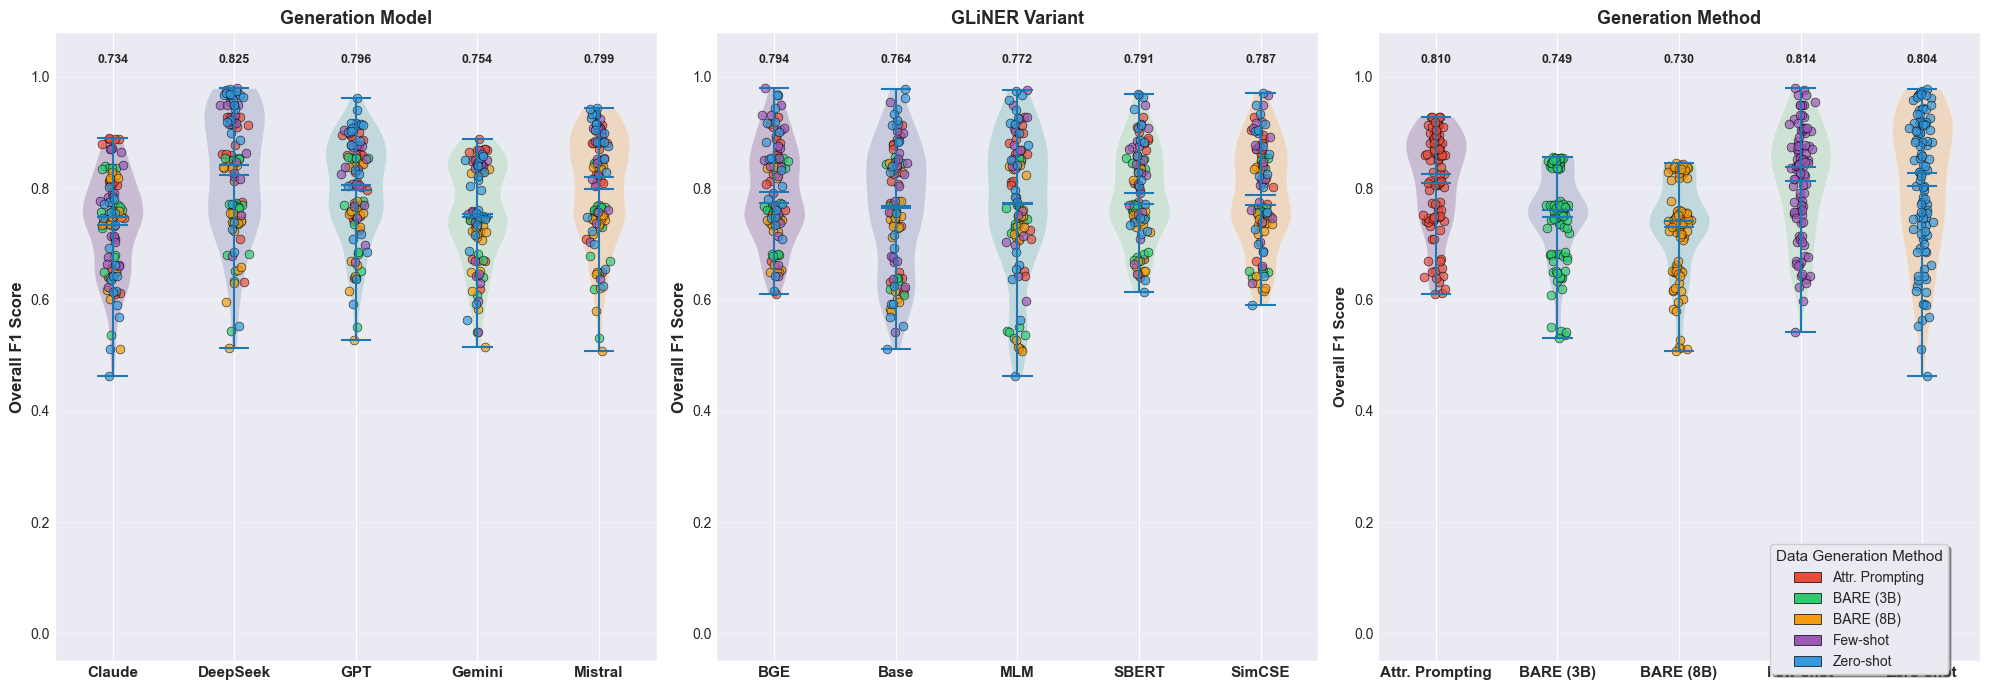

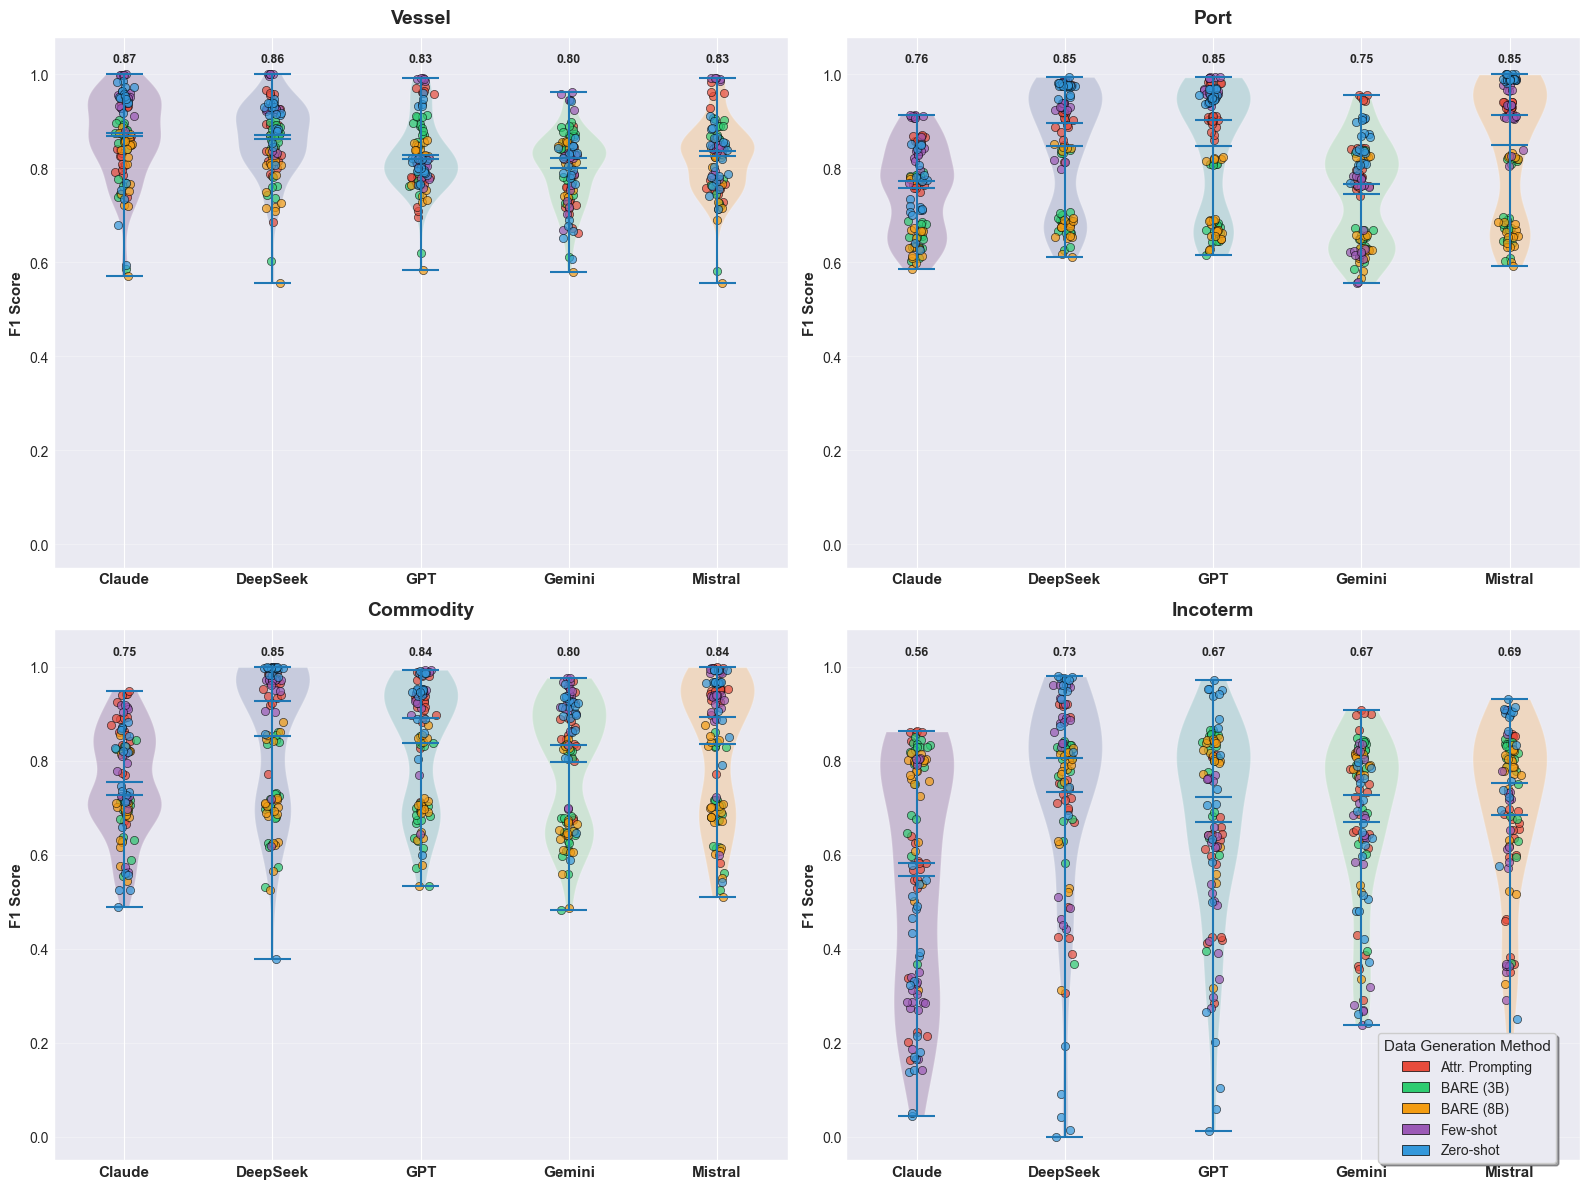

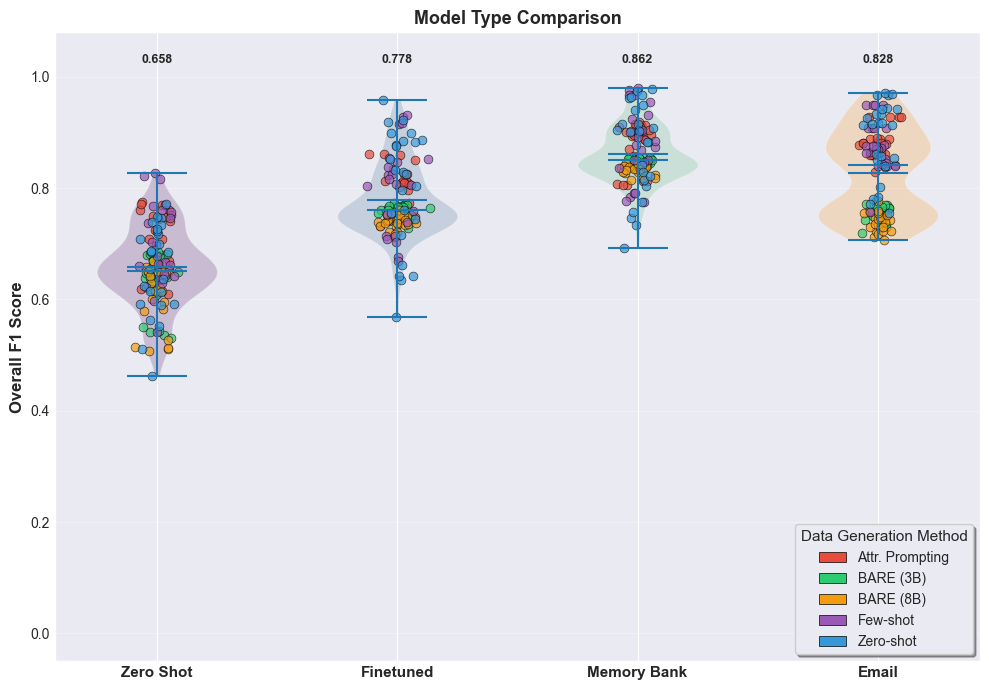


=== Summary Statistics ===

Mean F1 scores by generation method:
Attr. Prompting: 0.810
BARE (3B): 0.749
BARE (8B): 0.730
Few-shot: 0.814
Zero-shot: 0.804

Mean F1 scores by model type:
Zero Shot: 0.658
Finetuned: 0.778
Memory Bank: 0.862
Email: 0.828

Data generation methods found: ['Attr. Prompting', 'BARE (3B)', 'BARE (8B)', 'Few-shot', 'Zero-shot']


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import (viridis,
                           plasma)
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------
# Data Reading
# -------------------------------------------------------------------
df = pd.read_csv(r'C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\gliner_evaluation\gliner_eval_full.csv')

# -------------------------------------------------------------------
# Colors for Data Generation Methods
# -------------------------------------------------------------------
generation_palette = {
    'Zero-shot': '#3498db',          # Blue
    'Attr. Prompting': '#e74c3c',   # Red
    'BARE (3B)': '#2ecc71',         # Green
    'BARE (8B)': '#f39c12',         # Orange
    'Few-shot': '#9b59b6',          # Purple
    'Unknown': '#7f8c8d'            # Gray (fallback)
}

# -------------------------------------------------------------------
# Calculate Overall F1 Score
# -------------------------------------------------------------------
def calculate_overall_f1(row):
    """Calculate overall F1 as average of individual entity F1 scores"""
    entity_f1s = [row['vessel_f1'], row['port_f1'], row['commodity_f1'], row['incoterm_f1']]
    return np.mean(entity_f1s)

df['overall_f1'] = df.apply(calculate_overall_f1, axis=1)

# -------------------------------------------------------------------
# Extracting Generation Model
# -------------------------------------------------------------------
def extract_generation_model(dataset):
    if dataset.endswith('_gpt'):
        return 'GPT'

    elif dataset.endswith('_deepseek'):
        return 'DeepSeek'

    elif dataset.endswith('_gemini'):
        return 'Gemini'

    elif dataset.endswith('_claude'):
        return 'Claude'

    elif dataset.endswith('_mistral'):
        return 'Mistral'

    elif 'llama' in dataset:
        return 'Llama'

    else:
        return 'Unknown'

# -------------------------------------------------------------------
# Extraction Generation method
# -------------------------------------------------------------------
def extract_generation_method(dataset):
    if 'attr_prompting' in dataset:
        return 'Attr. Prompting'

    elif 'bare_llama_3b' in dataset:
        return 'BARE (3B)'

    elif 'bare_llama_8b' in dataset:
        return 'BARE (8B)'

    elif 'fewshot' in dataset:
        return 'Few-shot'

    elif 'zeroshot' in dataset:
        return 'Zero-shot'

    return 'Unknown'

# -------------------------------------------------------------------
# Model Groups
# -------------------------------------------------------------------
base_models = ['gliner_base',
               'gliner_sbert',
               'gliner_bge',
               'gliner_simcse',
               'gliner_mlm',
               'rule_based_tfidf']

finetuned_models = ['gliner_finetuned',
                    'gliner_finetued_sbert',
                    'gliner_finetuned_bge',
                    'gliner_finetuned_simcse',
                    'gliner_finetuned_mlm']

memory_bank_models = ['gliner_base_entity_aware',
                      'gliner_sbert_entity_aware',
                      'gliner_bge_entity_aware',
                      'gliner_simcse_entity_aware',
                      'gliner_mlm_entity_aware']

email_models = ['gliner_finetuned_email',
                'gliner_sbert_finetuned_email',
                'gliner_finetuned_bge_email',
                'gliner_finetuned_simcse_email',
                'gliner_finetuned_mlm_email']

# -------------------------------------------------------------------
# Model Renaming Dictionary
# -------------------------------------------------------------------
model_rename_dict = {

    # Base models
    'gliner_base': 'Base',
    'gliner_sbert': 'SBERT',
    'gliner_bge': 'BGE',
    'gliner_simcse': 'SimCSE',
    'gliner_mlm': 'MLM',
    'rule_based_tfidf': 'TF-IDF',

    # Finetuned models
    'gliner_finetuned': 'Base',
    'gliner_finetued_sbert': 'SBERT',
    'gliner_finetuned_sbert': 'SBERT',
    'gliner_finetuned_bge': 'BGE',
    'gliner_finetuned_simcse': 'SimCSE',
    'gliner_finetuned_mlm': 'MLM',

    # Memory bank models
    'gliner_base_entity_aware': 'Base',
    'gliner_sbert_entity_aware': 'SBERT',
    'gliner_bge_entity_aware': 'BGE',
    'gliner_simcse_entity_aware': 'SimCSE',
    'gliner_mlm_entity_aware': 'MLM',

    # Email finetuned models
    'gliner_finetuned_email': 'Base',
    'gliner_sbert_finetuned_email': 'SBERT',
    'gliner_finetuned_bge_email': 'BGE',
    'gliner_finetuned_simcse_email': 'SimCSE',
    'gliner_finetuned_mlm_email': 'MLM'
}


df['generation_model'] = df['dataset'].apply(extract_generation_model)
df['generation_method'] = df['dataset'].apply(extract_generation_method)
df['gliner_variant'] = df['model'].map(model_rename_dict)

def get_model_type(model_name):
    if model_name in base_models:
        return 'Zero Shot'
    elif model_name in finetuned_models:
        return 'Finetuned'
    elif model_name in memory_bank_models:
        return 'Memory Bank'
    elif model_name in email_models:
        return 'Email'
    else:
        return 'Unknown'

df['model_type'] = df['model'].apply(get_model_type)

gen_model_order = sorted(df['generation_model'].unique())
gliner_variant_order = sorted(df['gliner_variant'].dropna().unique())
gen_method_order = sorted(df['generation_method'].unique())


def get_viridis_colors(n):
    """Get n evenly spaced colors from the viridis colormap"""
    return [viridis(i / (n - 1)) for i in range(n)]

def get_custom_colors(n):
    """Get n evenly spaced colors from purple to orange"""
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#fde725']  # Original viridis
    colors = ['#440154', '#3b528b', '#21908c', '#5dc863', '#ff8c00']  # Dark orange instead of yellow

    cmap = mcolors.LinearSegmentedColormap.from_list('purple_to_orange', colors)

    return [cmap(i / (n - 1)) for i in range(n)]


max_categories = max(len(gen_model_order), len(gliner_variant_order), len(gen_method_order))
base_colors = get_custom_colors(max_categories)


# -------------------------------------------------------------------
# 1x3 Grid Plot - Generation Model | GLiNER Variant | Generation Method
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

ax = axes[0]
models = gen_model_order
violin_data = [df[df['generation_model'] == model]['overall_f1'].values for model in models]
violin_parts = ax.violinplot(violin_data, positions=range(len(models)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.2)

legend_handles = []
added_labels = set()

for i, model in enumerate(models):
    model_data = df[df['generation_model'] == model]

    for gen_method in model_data['generation_method'].unique():
        method_data = model_data[model_data['generation_method'] == gen_method]
        data = method_data['overall_f1'].values

        if len(data) > 0:
            y = data
            x = np.random.normal(i, 0.04, size=len(y))
            color = generation_palette.get(gen_method, '#7f8c8d')

            scatter = ax.scatter(x, y, alpha=0.7, s=40, color=color,
                               edgecolors='black', linewidth=0.5)

            if gen_method not in added_labels:
                legend_handles.append((scatter, gen_method))
                added_labels.add(gen_method)

    all_data = df[df['generation_model'] == model]['overall_f1'].values
    mean_val = np.mean(all_data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Generation Model', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

ax = axes[1]
variants = gliner_variant_order
violin_data = [df[df['gliner_variant'] == variant]['overall_f1'].values for variant in variants]
violin_parts = ax.violinplot(violin_data, positions=range(len(variants)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.2)

for i, variant in enumerate(variants):
    variant_data = df[df['gliner_variant'] == variant]

    for gen_method in variant_data['generation_method'].unique():
        method_data = variant_data[variant_data['generation_method'] == gen_method]
        data = method_data['overall_f1'].values

        if len(data) > 0:
            y = data
            x = np.random.normal(i, 0.04, size=len(y))
            color = generation_palette.get(gen_method, '#7f8c8d')
            ax.scatter(x, y, alpha=0.7, s=40, color=color,
                      edgecolors='black', linewidth=0.5)
    
    all_data = df[df['gliner_variant'] == variant]['overall_f1'].values
    mean_val = np.mean(all_data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(variants)))
ax.set_xticklabels(variants, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('GLiNER Variant', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

# Generation Method
ax = axes[2]
methods = gen_method_order
violin_data = [df[df['generation_method'] == method]['overall_f1'].values for method in methods]
violin_parts = ax.violinplot(violin_data, positions=range(len(methods)), showmeans=True, showmedians=True)

for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(base_colors[i])
    pc.set_alpha(0.2)  # Increased transparency

for i, method in enumerate(methods):
    method_data = df[df['generation_method'] == method]
    data = method_data['overall_f1'].values

    if len(data) > 0:
        y = data
        x = np.random.normal(i, 0.04, size=len(y))
        color = generation_palette.get(method, '#7f8c8d')
        ax.scatter(x, y, alpha=0.7, s=40, color=color,
                  edgecolors='black', linewidth=0.5)

    mean_val = np.mean(data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=11, fontweight="bold")
ax.set_title('Generation Method', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=generation_palette.get(label, '#7f8c8d'),
                        edgecolor='black', linewidth=0.5, label=label)
                  for _, label in legend_handles]
fig.legend(handles=legend_elements, title='Data Generation Method',
          fontsize=10, title_fontsize=11, loc='lower right',
          bbox_to_anchor=(0.98, 0.02), frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('violin_swarm_grid_1x3_viridis_f1_with_memory_bank_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# Entity Specific Scores with color-coding
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

entity_types = ['vessel_f1', 'port_f1', 'commodity_f1', 'incoterm_f1']
entity_labels = ['Vessel', 'Port', 'Commodity', 'Incoterm']

legend_handles = []
added_labels = set()

for idx, (entity, label) in enumerate(zip(entity_types, entity_labels)):
    ax = axes[idx]

    models = gen_model_order
    violin_data = [df[df['generation_model'] == model][entity].values for model in models]
    violin_parts = ax.violinplot(violin_data, positions=range(len(models)), showmeans=True, showmedians=True)

    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(base_colors[i])
        pc.set_alpha(0.2)

    for i, model in enumerate(models):
        model_data = df[df['generation_model'] == model]

        for gen_method in model_data['generation_method'].unique():
            method_data = model_data[model_data['generation_method'] == gen_method]
            data = method_data[entity].values

            if len(data) > 0:
                y = data
                x = np.random.normal(i, 0.03, size=len(y))
                color = generation_palette.get(gen_method, '#7f8c8d')

                scatter = ax.scatter(x, y, alpha=0.7, s=35, color=color,
                                   edgecolors='black', linewidth=0.5)

                if gen_method not in added_labels:
                    legend_handles.append((scatter, gen_method))
                    added_labels.add(gen_method)

        all_data = df[df['generation_model'] == model][entity].values
        mean_val = np.mean(all_data)
        ax.text(i, 1.02, f'{mean_val:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, fontsize=11, fontweight="bold")
    ax.set_ylabel('F1 Score', fontsize=11, fontweight="bold")
    ax.set_title(f'{label}', fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(-0.05, 1.08)

legend_elements = [Patch(facecolor=generation_palette.get(label, '#7f8c8d'),
                        edgecolor='black', linewidth=0.5, label=label)
                  for _, label in legend_handles]
fig.legend(handles=legend_elements, title='Data Generation Method',
          fontsize=10, title_fontsize=11, loc='lower right',
          bbox_to_anchor=(0.98, 0.02), frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('violin_swarm_entities_2x2_viridis_f1_with_memory_bank_colored.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------------------------------------------
# Model Type breakdown with color-coding
# -------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

model_types = ['Zero Shot', 'Finetuned', 'Memory Bank', 'Email']
model_type_data = [df[df['model_type'] == mt]['overall_f1'].values for mt in model_types]

model_types_filtered = []
model_type_data_filtered = []
for mt, data in zip(model_types, model_type_data):
    if len(data) > 0:
        model_types_filtered.append(mt)
        model_type_data_filtered.append(data)

violin_parts = ax.violinplot(model_type_data_filtered, positions=range(len(model_types_filtered)),
                            showmeans=True, showmedians=True)

colors = get_custom_colors(len(model_types_filtered))
for i, pc in enumerate(violin_parts['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_alpha(0.2)

legend_handles = []
added_labels = set()

for i, mt in enumerate(model_types_filtered):
    mt_data = df[df['model_type'] == mt]

    for gen_method in mt_data['generation_method'].unique():
        method_data = mt_data[mt_data['generation_method'] == gen_method]
        data = method_data['overall_f1'].values

        if len(data) > 0:
            y = data
            x = np.random.normal(i, 0.04, size=len(y))
            color = generation_palette.get(gen_method, '#7f8c8d')

            scatter = ax.scatter(x, y, alpha=0.7, s=40, color=color,
                               edgecolors='black', linewidth=0.5)

            if gen_method not in added_labels:
                legend_handles.append((scatter, gen_method))
                added_labels.add(gen_method)

    all_data = df[df['model_type'] == mt]['overall_f1'].values
    mean_val = np.mean(all_data)
    ax.text(i, 1.02, f'{mean_val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(range(len(model_types_filtered)))
ax.set_xticklabels(model_types_filtered, fontsize=11, fontweight="bold")
ax.set_ylabel('Overall F1 Score', fontsize=12, fontweight="bold")
ax.set_title('Model Type Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(-0.05, 1.08)

legend_elements = [Patch(facecolor=generation_palette.get(label, '#7f8c8d'),
                        edgecolor='black', linewidth=0.5, label=label)
                  for _, label in legend_handles]
ax.legend(handles=legend_elements, title='Data Generation Method',
         fontsize=10, title_fontsize=11, loc='lower right',
         frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig('violin_swarm_model_types_f1_colored.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Summary Statistics ===")
print("\nMean F1 scores by generation method:")
for method in gen_method_order:
    mean_f1 = df[df['generation_method'] == method]['overall_f1'].mean()
    print(f"{method}: {mean_f1:.3f}")

print("\nMean F1 scores by model type:")
for mt in model_types_filtered:
    mean_f1 = df[df['model_type'] == mt]['overall_f1'].mean()
    print(f"{mt}: {mean_f1:.3f}")

print("\nData generation methods found:", sorted(df['generation_method'].unique()))

Loading data and preparing for grouped box plot...
Reshaping data for grouped plotting...
Generating grouped box plot...


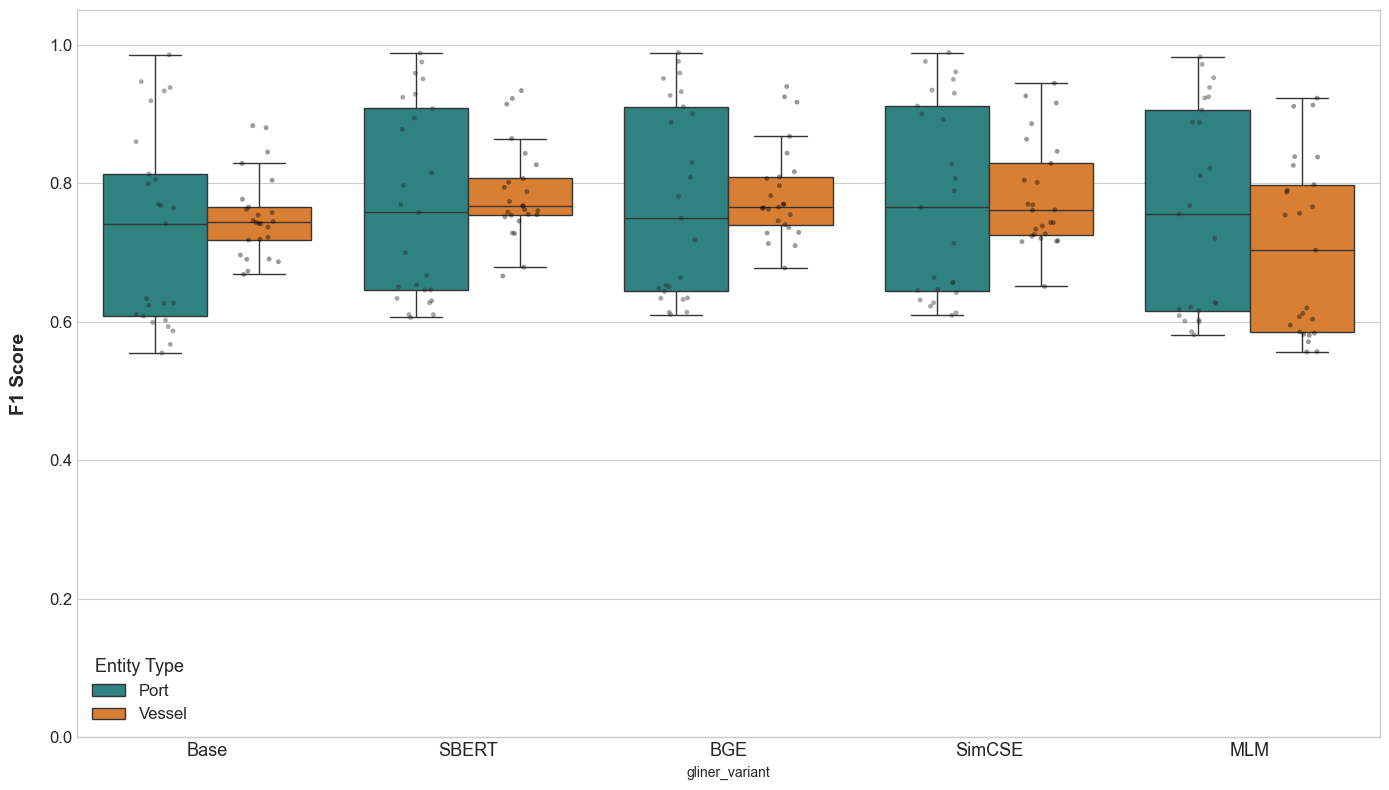


Plot successfully saved as 'grouped_box_plot_zero_shot_port_vessel.png'


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

def create_grouped_box_plot():
    """
    Generates a grouped box plot comparing port and vessel F1 scores
    for zero-shot GLiNER models, using data from the specified CSV file.
    """
    print("Loading data and preparing for grouped box plot...")
    try:
        df = pd.read_csv(r'C:\Users\brk.ch\Work Folders\RF\Desktop\Master Thesis\Repo\Masterthesis-dev\gliner_evaluation\gliner_eval_full.csv')
    except FileNotFoundError:
        print("Error: The file 'gliner_eval_full.csv' was not found.")
        print("Please ensure the file path is correct.")
        return

    base_models = ['gliner_base', 'gliner_sbert', 'gliner_bge', 'gliner_simcse', 'gliner_mlm']
    model_rename_dict = {
        'gliner_base': 'Base', 'gliner_sbert': 'SBERT', 'gliner_bge': 'BGE',
        'gliner_simcse': 'SimCSE', 'gliner_mlm': 'MLM'
    }

    df['model_type'] = df['model'].apply(lambda x: 'Zero Shot' if x in base_models else 'Other')
    df['gliner_variant'] = df['model'].map(model_rename_dict)

    df_zero_shot = df[df['model_type'] == 'Zero Shot'].copy()
    variant_order = ['Base', 'SBERT', 'BGE', 'SimCSE', 'MLM']
    df_zero_shot = df_zero_shot[df_zero_shot['gliner_variant'].isin(variant_order)]

    if df_zero_shot.empty:
        print("Error: No data found for Zero-Shot models. Please check the 'base_models' list and CSV contents.")
        return

    print("Reshaping data for grouped plotting...")
    df_melted = pd.melt(
        df_zero_shot,
        id_vars=['gliner_variant'],
        value_vars=['port_f1', 'vessel_f1'],
        var_name='entity_type',
        value_name='f1_score'
    )

    df_melted['entity_type'] = df_melted['entity_type'].map({
        'port_f1': 'Port',
        'vessel_f1': 'Vessel'
    })

    print("Generating grouped box plot...")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    custom_palette = {
        'Port': '#21908dff',
        'Vessel': '#f57d18ff'
    }

    sns.boxplot(
        data=df_melted,
        x='gliner_variant',
        y='f1_score',
        hue='entity_type',
        order=variant_order,
        hue_order=['Port', 'Vessel'],
        palette=custom_palette,
        ax=ax,
        fliersize=0
    )

    sns.stripplot(
        data=df_melted,
        x='gliner_variant',
        y='f1_score',
        hue='entity_type',
        order=variant_order,
        hue_order=['Port', 'Vessel'],
        color='black',
        alpha=0.4,
        jitter=0.15,
        dodge=True,
        size=3.5,
        ax=ax
    )

    ax.set_ylabel('F1 Score', fontsize=14, fontweight='bold', labelpad=15)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=12)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title='Entity Type', fontsize=12, title_fontsize=13, loc="lower left")

    plt.tight_layout()
    plt.savefig('grouped_box_plot_zero_shot_port_vessel.png', dpi=300)
    plt.show()
    print("\nPlot successfully saved as 'grouped_box_plot_zero_shot_port_vessel.png'")

if __name__ == '__main__':
    create_grouped_box_plot()